In [1]:
import torch
import os
import json
import sys
from torch.nn import CosineSimilarity
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizer
from functools import partial
from baukit import TraceDict
from einops import rearrange, einsum
from collections import defaultdict
import matplotlib.pyplot as plt
# from plotly_utils import imshow, scatter
from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
import math
import seaborn as sns
from peft import PeftModel
import pickle

import pysvelte
sys.path.append('../')
import analysis_utils
from counterfactual_datasets.entity_tracking import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(10)

%load_ext autoreload
%autoreload 2

In [2]:
print("Model Loading...")
path = "/data/nikhil_prakash/llama_weights/7B/"
# path = "AlekseyKorshuk/vicuna-7b"
# path = "/data/nikhil_prakash/goat-finetuning/weights_seed_3/checkpoint-800/"
# tokenizer = LlamaTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path).to(device)

# base_model = "decapoda-research/llama-7b-hf"
# lora_weights = "tiedong/goat-lora-7b"

tokenizer = LlamaTokenizer.from_pretrained('hf-internal-testing/llama-tokenizer', padding_side='right')

# model = LlamaForCausalLM.from_pretrained(
#     base_model,
#     load_in_8bit=False,
#     torch_dtype=torch.float32,
#     device_map="auto",
# )
# model = PeftModel.from_pretrained(
#     model,
#     lora_weights,
#     torch_dtype=torch.float32,
#     device_map={'': 0},
# )

tokenizer.pad_token_id = tokenizer.eos_token_id

Model Loading...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Evaluating Models

In [7]:
data_file = "../box_datasets/no_instructions/alternative/Random/7/train.jsonl"
object_file = "../box_datasets/filtered_objects_with_bnc_frequency.csv"
batch_size = 50

In [8]:
raw_data = entity_tracking_example_sampler(
    tokenizer=tokenizer,
    num_samples=500,
    data_file=data_file,
    # object_file=object_file,
    few_shot=False,
    alt_examples=True,
    # num_ents_or_ops=3,
    architecture="LlamaForCausalLM",
)

dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
        "labels": raw_data[2],
    }
).with_format("torch")

print(f"Length of dataset: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=batch_size)

Length of dataset: 500


In [9]:
idx = 0
print(
    f"Prompt: {tokenizer.decode(dataset[idx]['input_ids'][:dataset[idx]['last_token_indices']+1])}"
)
print(f"Answer: {tokenizer.decode(dataset[idx]['labels'])}")

Prompt: <s>The document is in Box X, the pot is in Box T, the magnet is in Box A, the game is in Box E, the bill is in Box M, the cross is in Box K, the map is in Box D. Box X contains the
Answer: document


In [6]:
total_count = 0
correct_count = 0
model.eval()
errors = defaultdict(int)
with torch.no_grad():
    for _, output in tqdm(enumerate(tqdm(dataloader))):
        for k, v in output.items():
            if v is not None and isinstance(v, torch.Tensor):
                output[k] = v.to(model.device)

        outputs = model(input_ids=output["input_ids"])

        for bi in range(output["labels"].size(0)):
            label = output["labels"][bi]
            pred = torch.argmax(outputs.logits[bi][output["last_token_indices"][bi]])
            box_label = output["input_ids"][bi][output["last_token_indices"][bi] - 2]
            prev_box_label_pos = output["input_ids"][bi].eq(box_label).nonzero()[:, 0][0].item()
            prev_box_label_index = prev_box_label_pos // 8 + 1

            if label == pred:
                correct_count += 1
            else:
                errors[prev_box_label_index] += 1
                # print(prev_box_label_pos, prev_box_label_index)
                # print(f"Label: {tokenizer.decode(label)}, Prediction: {tokenizer.decode(pred)}")
            total_count += 1

del outputs
torch.cuda.empty_cache()

current_acc = round(correct_count / total_count, 2)
print(f"Task accuracy: {current_acc}")

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:20<00:00,  2.05s/it]
10it [00:20,  2.05s/it]

Task accuracy: 0.66


## Visualizing Head Attention

In [67]:
layer = 21
attn_scores, value_vectors = analysis_utils.get_attn_scores(model, base_tokens, layer)

In [68]:
value_vectors_norm = torch.norm(value_vectors, dim=-1)
scaled_attn = einsum(
    value_vectors_norm,
    attn_scores,
    "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
)

In [72]:
index = 3
print(f"layer: {layer}, Bi: {index}")
pysvelte.AttentionMulti(
    tokens=[tokenizer.decode(token) for token in base_tokens[index].cpu().tolist()],
    attention=scaled_attn[index].permute(1, 2, 0).cpu(),
).show()

layer: 21, Bi: 3


### Ablating Correct Object Locator Heads in the Forward Setting

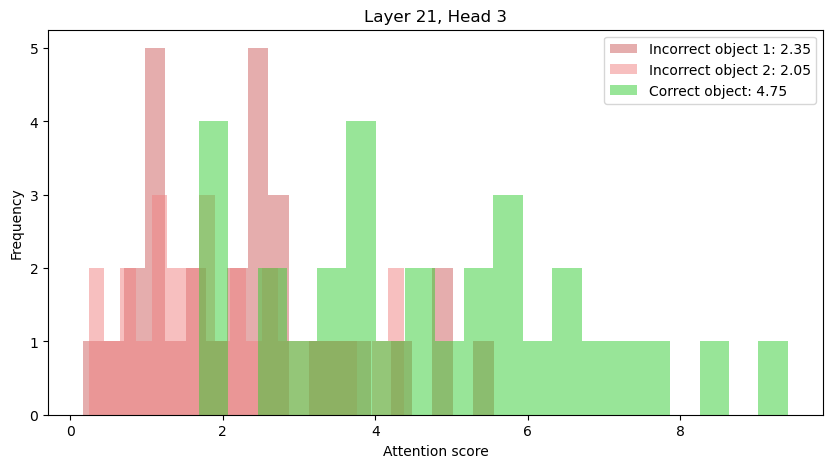

In [14]:
# Attention to objects in the context

correct_object_attn_scores = defaultdict(list)
incorrect_object_1_attn_scores = defaultdict(list)
incorrect_object_2_attn_scores = defaultdict(list)
self_attn_scores = defaultdict(list)
ablation_heads = [[14, 27], [11, 23], [12, 23]]

for layer, head in direct_logit_heads:
    attn_scores, value_vectors = analysis_utils.get_attn_scores(
        model,
        base_tokens,
        layer,
        ablation_heads=ablation_heads,
        last_token_pos=base_last_token_indices,
    )
    value_vectors_norm = torch.norm(value_vectors, dim=-1)
    attn_scores = einsum(
        value_vectors_norm,
        attn_scores,
        "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
    )

    for bi in range(base_tokens.size(0)):
        correct_object = correct_answer_token[bi]
        incorrect_objects = incorrect_answer_token[bi]

        context = base_tokens[bi][: base_last_token_indices[bi] - 3]
        correct_object_pos_start = [
            pos for pos, token in enumerate(context) if token == correct_object
        ][0]
        correct_object_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > correct_object_pos_start)
        ][0]

        incorrect_obj_1_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[0]
        ][0]
        incorrect_obj_1_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > incorrect_obj_1_pos_start)
        ][0]

        incorrect_obj_2_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[1]
        ][0]
        incorrect_obj_2_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > incorrect_obj_2_pos_start)
        ][0]

        self_attn_scores[(layer, head)].append(
            attn_scores[bi, head, base_last_token_indices[bi], base_last_token_indices[bi]].item()
        )
        correct_object_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    correct_object_pos_start:correct_object_pos_end,
                ]
            ).item()
        )
        incorrect_object_1_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_1_pos_start:incorrect_obj_1_pos_end,
                ]
            ).item()
        )
        incorrect_object_2_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_2_pos_start:incorrect_obj_2_pos_end,
                ]
            ).item()
        )

    # Plotting
    plt.figure(figsize=(10, 5))
    # plt.hist(self_attn_scores[(layer, head)], bins=20, alpha=0.5, label=f"Self: {round(np.mean(self_attn_scores[(layer, head)]), 2)}", color="red")
    plt.hist(
        incorrect_object_1_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Incorrect object 1: {round(np.mean(incorrect_object_1_attn_scores[(layer, head)]), 2)}",
        color="indianred",
    )
    plt.hist(
        incorrect_object_2_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Incorrect object 2: {round(np.mean(incorrect_object_2_attn_scores[(layer, head)]), 2)}",
        color="lightcoral",
    )
    plt.hist(
        correct_object_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Correct object: {round(np.mean(correct_object_attn_scores[(layer, head)]), 2)}",
        color="limegreen",
    )
    plt.ylabel("Frequency")
    plt.xlabel("Attention score")
    # plt.xlim([0, 1])
    plt.title(f"Layer {layer}, Head {head}")
    plt.legend()

    #     plt.savefig(
    #         os.path.join(
    #             "result_plots",
    #             "alternate_format",
    #             "attn_score_of_logit_heads",
    #             "attn_scores_{}_{}.png".format(layer, head),
    #         ),
    #         dpi=300,
    #         bbox_inches="tight",
    #     )
    plt.show()

### Activation Patching on Object Attender Heads

In [117]:
base_prompt = "Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box X contains the"
base_tokens = tokenizer(base_prompt, return_tensors="pt").input_ids.to(device)
last_base_token_pos = (
    tokenizer(base_prompt, return_tensors="pt").attention_mask.to(device).sum(dim=-1) - 1
)
source_prompt = "Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the"
source_tokens = tokenizer.encode(source_prompt, return_tensors="pt").to(device)
last_source_token_pos = (
    tokenizer(source_prompt, return_tensors="pt").attention_mask.to(device).sum(dim=-1) - 1
)

In [118]:
ablation_heads = heads_influencing_object_value_fetcher_heads
modules = list(set([f"model.layers.{layer}.self_attn.o_proj" for layer, _ in ablation_heads]))

In [119]:
with torch.no_grad():
    with TraceDict(model, modules, retain_input=True) as source_cache:
        _ = model(source_tokens)

In [132]:
def patch_head_output(
    inputs=None, output=None, layer=None, heads=None, base_last=None, source_last=None
):
    input = inputs[0]
    # print(input.shape)
    input = rearrange(
        input,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )
    cache = rearrange(
        source_cache[layer].output,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    heads_at_curr_layer = [h for l, h in heads if l == int(layer.split(".")[2])]
    # print(heads_at_curr_layer, layer)

    for head in heads_at_curr_layer:
        input[0, base_last, head] = cache[0, source_last, head]

    input = rearrange(
        input,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )
    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(
        input, w_o, "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model"
    )

    return output

In [133]:
with torch.no_grad():
    with TraceDict(
        model,
        modules,
        retain_input=True,
        edit_output=partial(
            patch_head_output,
            heads=ablation_heads,
            base_last=last_base_token_pos,
            source_last=last_source_token_pos,
        ),
    ) as _:
        output = model(base_tokens)

In [134]:
logit, pred = torch.max(output.logits[0, -1], dim=-1)
print(f"{base_prompt}: '{tokenizer.decode(pred)}', {round(logit.item(), 2)}")
print(f"{source_prompt}")

Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box X contains the: ' glass', 14.51
Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the


In [70]:
output = model(source_tokens)
pred = torch.argmax(output.logits[0, -1], dim=-1).item()
print(f"{source_prompt}: '{tokenizer.decode(pred)}'")

Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the: ' lady'


### Patching Residual Stream

In [24]:
original = (
    "The bill is in Box X, the chemical is in Box T, the medicine is in Box A. Box E contains the"
)
original_tokens = tokenizer.encode(original, return_tensors="pt").to(device)
alternative = (
    "The apple is in Box A, the banana is in Box T, the bell is in Box X. Box X contains the"
)
alternative_tokens = tokenizer.encode(alternative, return_tensors="pt").to(device)

modules = [f"model.layers.{layer}" for layer in range(32)]

In [25]:
with TraceDict(model, modules) as cache:
    _ = model(alternative_tokens)

In [30]:
def patch_residual(output, layer):
    residual = cache[layer].output
    output[0][:, -1] = residual[0][:, -1]

    return output

In [31]:
for layer in range(32):
    with TraceDict(model, [f"model.layers.{layer}"], edit_output=patch_residual) as _:
        output = model(original_tokens)
    logit, pred = torch.max(output.logits[0, -1], dim=-1)
    print(f"Layer: {layer}: '{tokenizer.decode(pred)}', {round(logit.item(), 2)}")

Layer: 0: ' key', 13.33
Layer: 1: ' key', 13.32
Layer: 2: ' key', 13.33
Layer: 3: ' key', 13.33
Layer: 4: ' key', 13.34
Layer: 5: ' key', 13.33
Layer: 6: ' key', 13.33
Layer: 7: ' key', 13.32
Layer: 8: ' key', 13.37
Layer: 9: ' key', 13.38
Layer: 10: ' key', 13.41
Layer: 11: ' chemical', 13.33
Layer: 12: ' chemical', 13.4
Layer: 13: ' chemical', 13.86
Layer: 14: ' medicine', 15.16
Layer: 15: ' chemical', 14.88
Layer: 16: ' chemical', 15.37
Layer: 17: ' chemical', 15.01
Layer: 18: ' chemical', 14.65
Layer: 19: ' chemical', 14.5
Layer: 20: ' bell', 15.51
Layer: 21: ' bell', 15.67
Layer: 22: ' bell', 15.56
Layer: 23: ' bell', 15.66
Layer: 24: ' bell', 15.41
Layer: 25: ' bell', 15.37
Layer: 26: ' bell', 15.28
Layer: 27: ' bell', 15.32
Layer: 28: ' bell', 15.55
Layer: 29: ' bell', 15.52
Layer: 30: ' bell', 15.73
Layer: 31: ' bell', 16.24


The engine is in Box S, the machine is in Box L, the brain is in Box I. Box I contains the: ' brain', 12.91


In [64]:
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids):
    # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [65]:
def intervention_wrapper(batch_size, seq_len, from_pos, to_pos):
    def attention_knockout(inputs, output, layer):
        if "norm" in layer:
            return output
        global queries, keys, attn_outputs
        n_heads = model.config.num_attention_heads
        d_model = model.config.hidden_size
        d_head = d_model // n_heads
        layer_index = int(layer.split(".")[4])

        if "q_proj" in layer:
            query = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            queries[layer_index] = query

        elif "k_proj" in layer:
            key = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            keys[layer_index] = key

        elif "v_proj" in layer:
            value = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            key = keys[layer_index]
            query = queries[layer_index]

            kv_seq_len = key.shape[-2]
            cos, sin = model.base_model.model.model.layers[layer_index].self_attn.rotary_emb(
                value, seq_len=kv_seq_len
            )
            positions = [i for i in range(seq_len)]
            positions = torch.tensor(positions).unsqueeze(0).repeat(batch_size, 1).to(device)
            query, key = apply_rotary_pos_emb(query, key, cos, sin, positions)

            attn_scores = einsum(
                key,
                query,
                "batch n_heads key_pos d_head, batch n_heads query_pos d_head -> batch n_heads query_pos key_pos",
            )
            attn_scores = attn_scores / math.sqrt(d_head)
            attn_scores = apply_causal_mask(attn_scores, layer, from_pos, to_pos)
            attn_scores = torch.softmax(attn_scores, dim=-1)
            attn_output = einsum(
                attn_scores,
                value,
                "batch n_heads query_pos key_pos, batch n_heads key_pos d_head -> batch query_pos n_heads d_head",
            )
            attn_output = attn_output.reshape(batch_size, seq_len, d_model)
            attn_outputs[layer_index] = attn_output

        elif "o_proj" in layer:
            attn_output = attn_outputs[layer_index]
            o_proj_weight = model.state_dict()[f"{layer}.weight"]
            output = einsum(
                attn_output,
                o_proj_weight,
                "batch seq_len d_model, hidden_size d_model -> batch seq_len hidden_size",
            )
            return output
        else:
            return output

    return attention_knockout

In [66]:
def compute_prev_query_box_pos(input_ids, last_token_index):
    query_box_token = input_ids[last_token_index - 2]
    prev_query_box_token_pos = (
        (input_ids[: last_token_index - 2] == query_box_token).nonzero().item()
    )
    return prev_query_box_token_pos

In [53]:
def compute_segments(inputs, correct_object_pos):
    segs = []
    segments = defaultdict(list)

    seg_end_pos = torch.cat([inputs.eq(29892).nonzero()[:, 1], inputs.eq(29889).nonzero()[:, 1]])
    for seg_idx in range(seg_end_pos.size(0)):
        segs.append(
            torch.arange(
                seg_end_pos[seg_idx - 1] + 1 if seg_idx > 0 else 1, seg_end_pos[seg_idx] + 1
            )
        )
    for seg in segs:
        if correct_object_pos in seg:
            segments["correct_obj"] = seg
        else:
            if "incorrect_obj_1" not in segments:
                segments["incorrect_obj_1"] = seg
            else:
                segments["incorrect_obj_2"] = seg

    return segments

In [54]:
def apply_causal_mask(attn_scores, layer, from_pos, to_pos):
    ignore = torch.tensor(torch.finfo(attn_scores.dtype).min)
    mask = torch.triu(
        torch.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device),
        diagonal=1,
    ).bool()
    attn_scores.masked_fill_(mask, ignore)

    # Attention knockout
    # layer_index = int(layer.split('.')[2])
    attn_scores[:, :, from_pos, to_pos] = ignore

    return attn_scores

In [56]:
accuracies = defaultdict(float)
comma_token = 29892
period_token = 29889
for knockout_layer in range(0, model.config.num_hidden_layers):
    modules = [
        [
            f"base_model.model.model.layers.{i}.self_attn.k_proj",
            f"base_model.model.model.layers.{i}.self_attn.q_proj",
            f"base_model.model.model.layers.{i}.self_attn.v_proj",
            f"base_model.model.model.layers.{i}.self_attn.o_proj",
        ]
        for i in range(knockout_layer, model.config.num_hidden_layers)
    ]

    modules = [item for sublist in modules for item in sublist]
    queries, keys, attn_outputs = {}, {}, {}

    model.eval()
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, input in tqdm(enumerate(tqdm(dataloader)), desc=f"{knockout_layer}"):
            for k, v in input.items():
                if v is not None and isinstance(v, torch.Tensor):
                    input[k] = v.to(model.device)

            batch_size, seq_len = input["input_ids"].shape
            prev_box_label_index = compute_prev_query_box_pos(
                input["input_ids"][0], input["last_token_indices"][0]
            )
            correct_obj_pos = prev_box_label_index - 5

            with TraceDict(
                model,
                modules,
                retain_output=True,
                edit_output=intervention_wrapper(
                    batch_size,
                    seq_len,
                    from_pos=input["last_token_indices"],
                    to_pos=correct_obj_pos,
                ),
            ) as _:
                outputs = model(input_ids=input["input_ids"])

            for bi in range(input["labels"].size(0)):
                label = input["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][input["last_token_indices"][bi]])

                if label == pred:
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    accuracies[knockout_layer] = round(correct_count / total_count, 2)

    print(f"Knockout Starting Layer {knockout_layer} acc: {accuracies[knockout_layer]}")

  0%|          | 0/100 [00:00<?, ?it/s]100%|██████████| 100/100 [00:24<00:00,  4.01it/s]
0: 100it [00:24,  4.01it/s]


Knockout Starting Layer 0 acc: 0.82


100%|██████████| 100/100 [00:24<00:00,  4.03it/s]
1: 100it [00:24,  4.03it/s]


Knockout Starting Layer 1 acc: 0.77


100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
2: 100it [00:23,  4.18it/s]


Knockout Starting Layer 2 acc: 0.77


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]
3: 100it [00:23,  4.27it/s]


Knockout Starting Layer 3 acc: 0.76


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]
4: 100it [00:23,  4.31it/s]


Knockout Starting Layer 4 acc: 0.76


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]
5: 100it [00:22,  4.47it/s]


Knockout Starting Layer 5 acc: 0.76


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]
6: 100it [00:22,  4.51it/s]


Knockout Starting Layer 6 acc: 0.79


100%|██████████| 100/100 [00:21<00:00,  4.60it/s]
7: 100it [00:21,  4.60it/s]


Knockout Starting Layer 7 acc: 0.79


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]
8: 100it [00:21,  4.70it/s]


Knockout Starting Layer 8 acc: 0.79


100%|██████████| 100/100 [00:20<00:00,  4.87it/s]
9: 100it [00:20,  4.87it/s]


Knockout Starting Layer 9 acc: 0.76


100%|██████████| 100/100 [00:20<00:00,  4.94it/s]
10: 100it [00:20,  4.94it/s]


Knockout Starting Layer 10 acc: 0.81


100%|██████████| 100/100 [00:19<00:00,  5.03it/s]
11: 100it [00:19,  5.03it/s]


Knockout Starting Layer 11 acc: 0.8


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]
12: 100it [00:19,  5.14it/s]


Knockout Starting Layer 12 acc: 0.79


100%|██████████| 100/100 [00:19<00:00,  5.24it/s]
13: 100it [00:19,  5.24it/s]


Knockout Starting Layer 13 acc: 0.81


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]
14: 100it [00:18,  5.36it/s]


Knockout Starting Layer 14 acc: 0.8


100%|██████████| 100/100 [00:17<00:00,  5.68it/s]
15: 100it [00:17,  5.68it/s]


Knockout Starting Layer 15 acc: 0.8


100%|██████████| 100/100 [00:17<00:00,  5.73it/s]
16: 100it [00:17,  5.73it/s]


Knockout Starting Layer 16 acc: 0.85


100%|██████████| 100/100 [00:16<00:00,  5.93it/s]
17: 100it [00:16,  5.93it/s]


Knockout Starting Layer 17 acc: 0.85


100%|██████████| 100/100 [00:16<00:00,  6.11it/s]
18: 100it [00:16,  6.11it/s]


Knockout Starting Layer 18 acc: 0.85


100%|██████████| 100/100 [00:15<00:00,  6.32it/s]
19: 100it [00:15,  6.32it/s]


Knockout Starting Layer 19 acc: 0.84


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]
20: 100it [00:15,  6.50it/s]


Knockout Starting Layer 20 acc: 0.84


100%|██████████| 100/100 [00:14<00:00,  6.91it/s]
21: 100it [00:14,  6.91it/s]


Knockout Starting Layer 21 acc: 0.83


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]
22: 100it [00:14,  7.05it/s]


Knockout Starting Layer 22 acc: 0.84


100%|██████████| 100/100 [00:13<00:00,  7.47it/s]
23: 100it [00:13,  7.47it/s]


Knockout Starting Layer 23 acc: 0.84


100%|██████████| 100/100 [00:12<00:00,  7.69it/s]
24: 100it [00:12,  7.69it/s]


Knockout Starting Layer 24 acc: 0.85


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]
25: 100it [00:12,  8.25it/s]


Knockout Starting Layer 25 acc: 0.85


26: 14it [00:01,  8.17it/s]:01<00:10,  8.55it/s]
 14%|█▍        | 14/100 [00:01<00:10,  8.16it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:42                                                                                   │
│                                                                                                  │
│   39 │   │   │   │   │   to_pos=correct_obj_pos                                                  │
│   40 │   │   │   │   ),                                                                          │
│   41 │   │   │   ) as _:                                                                         │
│ ❱ 42 │   │   │   │   outputs = model(input_ids=input["input_ids"])                               │
│   43 │   │   │                                                                                   │
│   44 │   │   │   for bi in range(input["labels"].size(0)):                                       │
│   45 │   │   │   │   label = input["labels"][bi]                                                 │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/peft/peft_model.py:857 in      │
│ forward                                                                                          │
│                                                                                                  │
│    854 │   │   │   │   │   **kwargs,                                                             │
│    855 │   │   │   │   )                                                                         │
│    856 │   │   │                                                                                 │
│ ❱  857 │   │   │   return self.base_model(                                                       │
│    858 │   │   │   │   input_ids=input_ids,                                                      │
│    859 │   │   │   │   attention_mask=attention_mask,                                            │
│    860 │   │   │   │   inputs_embeds=inputs_embeds,                                              │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)    

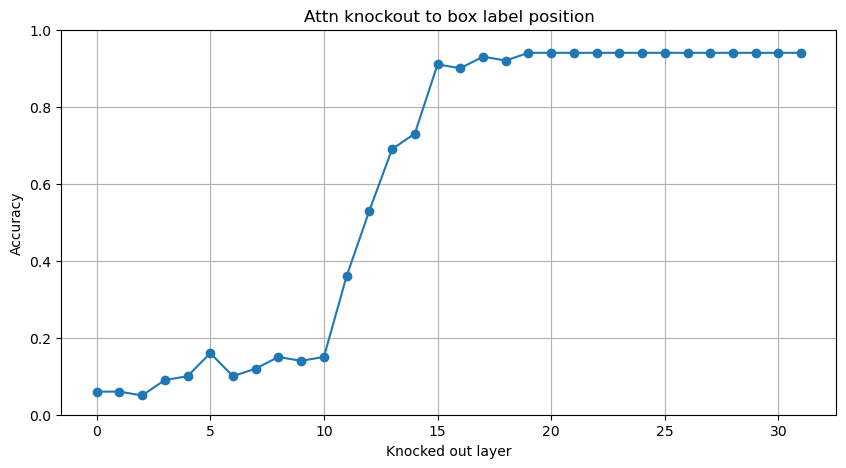

In [17]:
# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker="o")
plt.xlabel("Knocked out layer")
plt.ylabel("Accuracy")
plt.title("Attn knockout to box label position")
plt.ylim([0, 1])
plt.grid()
plt.show()

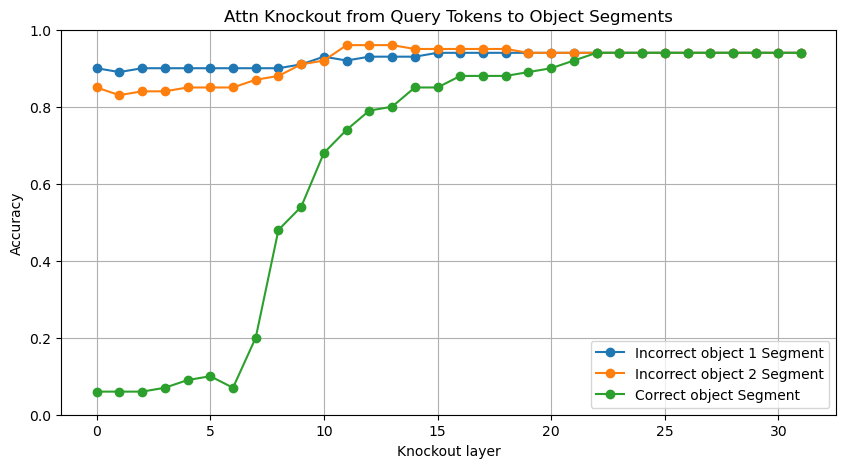

In [42]:
# plot accuracies for each knockout layer
plt.figure(figsize=(10, 5))
plt.plot(
    list(accuracies.keys()),
    [acc[1] for acc in accuracies.values()],
    label="Incorrect object 1 Segment",
    marker="o",
)
plt.plot(
    list(accuracies.keys()),
    [acc[2] for acc in accuracies.values()],
    label="Incorrect object 2 Segment",
    marker="o",
)
plt.plot(
    list(accuracies.keys()),
    [acc[0] for acc in accuracies.values()],
    label="Correct object Segment",
    marker="o",
)
plt.title("Attn Knockout from Query Tokens to Object Segments")
plt.xlabel("Knockout layer")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

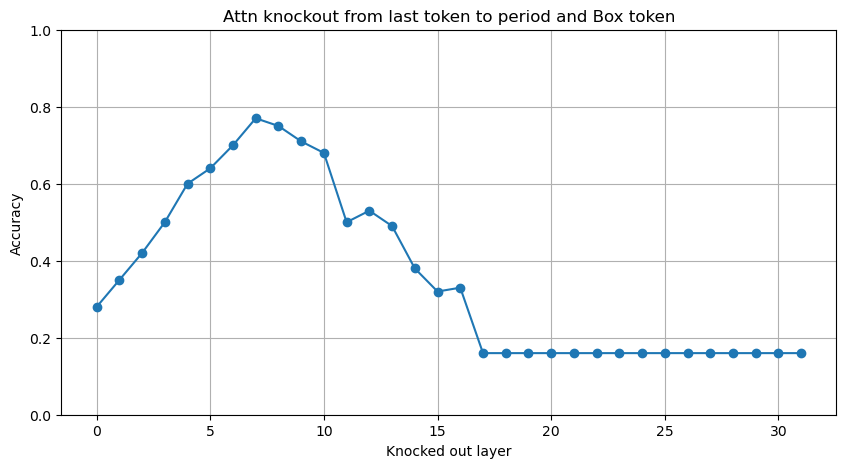

Text(0.5, 1.0, 'Attn Knockout from Query Tokens to Correct Object Segment')

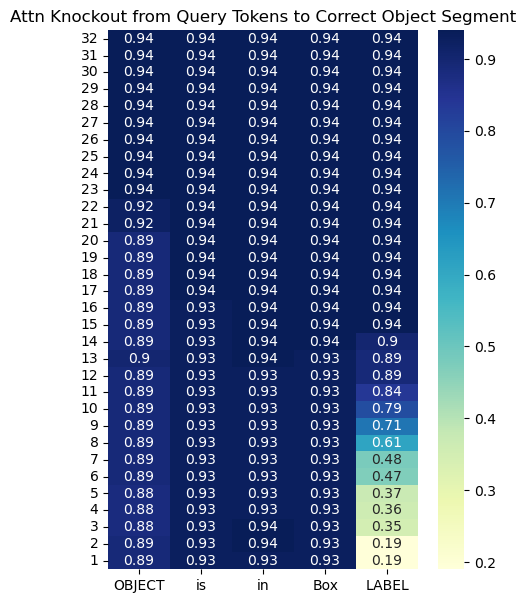

In [47]:
# Plot a heatmap of accuracies
accuracies_list = np.array(list(accuracies.values()))
accuracies_list = np.flip(accuracies_list, axis=0)

plt.figure(figsize=(5, 7))
sns.heatmap(
    accuracies_list,
    annot=True,
    cmap="YlGnBu",
    yticklabels=[i for i in range(32, 0, -1)],
    xticklabels=["OBJECT", "is", "in", "Box", "LABEL"],
)
plt.title("Attn Knockout from Query Tokens to Correct Object Segment")

## Evaluation Metrics

### Faithfulness

In [10]:
data_file = "../box_datasets/no_instructions/alternative/Random/7/train.jsonl"
object_file = "../box_datasets/filtered_objects_with_bnc_frequency.csv"
batch_size = 50

In [11]:
raw_data = generate_data_for_eval(
    tokenizer=tokenizer,
    num_samples=3500,
    data_file=data_file,
    num_boxes=7,
)

ablate_dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
    }
).with_format("torch")

print(f"Length of dataset: {len(ablate_dataset)}")

ablate_dataloader = DataLoader(ablate_dataset, batch_size=batch_size)

Length of dataset: 500


In [12]:
idx = 0
print(
    f"Prompt: {tokenizer.decode(dataset[idx]['input_ids'][:dataset[idx]['last_token_indices']+1])}"
)

Prompt: <s>The document is in Box X, the pot is in Box T, the magnet is in Box A, the game is in Box E, the bill is in Box M, the cross is in Box K, the map is in Box D. Box X contains the


In [13]:
if model.config.architectures[0] == "LlamaForCausalLM":
    modules = [f"model.layers.{layer}.self_attn.o_proj" for layer in range(32)]
else:
    modules = [f"base_model.model.model.layers.{layer}.self_attn.o_proj" for layer in range(32)]

mean_activations = {}
with torch.no_grad():
    # Assuming a single batch
    for _, output in enumerate(tqdm(ablate_dataloader)):
        for k, v in output.items():
            if v is not None and isinstance(v, torch.Tensor):
                output[k] = v.to(model.device)

        with TraceDict(model, modules, retain_input=True) as cache:
            _ = model(output["input_ids"])

        for layer in modules:
            if "self_attn" in layer:
                if layer in mean_activations:
                    mean_activations[layer] += torch.mean(cache[layer].input, dim=0)
                else:
                    mean_activations[layer] = torch.mean(cache[layer].input, dim=0)
            else:
                if layer in mean_activations:
                    mean_activations[layer] += torch.mean(cache[layer].output, dim=0)
                else:
                    mean_activations[layer] = torch.mean(cache[layer].output, dim=0)

        del cache
        torch.cuda.empty_cache()

    for layer in modules:
        mean_activations[layer] /= len(ablate_dataloader)

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


In [14]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=63, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=15, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=30, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)


for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)

for pos in circuit_components.keys():
    for layer_idx in circuit_components[pos].keys():
        circuit_components[pos][layer_idx] = list(set(circuit_components[pos][layer_idx]))

50 15 30 5


In [15]:
def mean_ablate(inputs, output, layer, circuit_components, mean_activations, input_tokens):
    if isinstance(inputs, tuple):
        inputs = inputs[0]

    if isinstance(output, tuple):
        output = output[0]

    inputs = rearrange(
        inputs,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    mean_act = rearrange(
        mean_activations[layer],
        "seq_len (n_heads d_head) -> 1 seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    last_pos = inputs.size(1) - 1
    for bi in range(inputs.size(0)):
        prev_query_box_pos = analysis_utils.compute_prev_query_box_pos(
            input_tokens[bi], input_tokens[bi].size(0) - 1
        )
        for token_pos in range(inputs.size(1)):
            if (
                token_pos != prev_query_box_pos
                and token_pos != last_pos
                and token_pos != last_pos - 2
                and token_pos != prev_query_box_pos + 1
            ):
                inputs[bi, token_pos, :] = mean_act[0, token_pos, :]
            elif token_pos == prev_query_box_pos:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[-1][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[0, token_pos, head_idx]
            elif token_pos == prev_query_box_pos + 1:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[-2][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[0, token_pos, head_idx]
            elif token_pos == last_pos:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[0][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[0, token_pos, head_idx]
            elif token_pos == last_pos - 2:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[2][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[0, token_pos, head_idx]

    inputs = rearrange(
        inputs,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )
    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(
        inputs, w_o, "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model"
    )

    return output

In [16]:
def eval(model, dataloader, modules, circuit_components, mean_activations):
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, output in enumerate(tqdm(dataloader)):
            for k, v in output.items():
                if v is not None and isinstance(v, torch.Tensor):
                    output[k] = v.to(model.device)
    
            with TraceDict(
                model,
                modules,
                retain_input=True,
                edit_output=partial(
                    mean_ablate,
                    circuit_components=circuit_components,
                    mean_activations=mean_activations,
                    input_tokens=output["input_ids"],
                ),
            ) as _:
                outputs = model(output["input_ids"])
    
            for bi in range(output["labels"].size(0)):
                label = output["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][output["last_token_indices"][bi]])
    
                if label == pred:
                    correct_count += 1
                # else:
                #     print(f"Label: {tokenizer.decode(label)}, Prediction: {tokenizer.decode(pred)}")
                total_count += 1
    
            del outputs
            torch.cuda.empty_cache()
    
    current_acc = round(correct_count / total_count, 2)
    print(f"Task accuracy: {current_acc}")
    return current_acc

In [14]:
eval(model, dataloader, modules, circuit_components, mean_activations)

100%|██████████| 10/10 [01:03<00:00,  6.38s/it]

Task accuracy: 0.57


0.57

## Minimality

### heads_at_prev_query_box_pos - Llama

In [27]:
import time

circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=60, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=10, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=35, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

print("original res:")

eval(model, dataloader, modules, circuit_components, mean_activations)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    print(layer, head)
    circuit_components[-1][layer].append(head)
    eval(model, dataloader, modules, circuit_components, mean_activations)

    circuit_components[-1][layer].pop()

# for pos in circuit_components.keys():
#     for layer_idx in circuit_components[pos].keys():
#         circuit_components[pos][layer_idx] = list(set(circuit_components[pos][layer_idx]))

50 10 35 5
original res:


  0%|          | 0/6 [00:05<?, ?it/s]


KeyboardInterrupt: 

###  head_at_query_box_token

In [41]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=60, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=10, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=35, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)



for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


print("original res:")

eval(model, dataloader, modules, circuit_components, mean_activations)

for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    print(layer, head)
    circuit_components[2][layer].append(head)
    eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[2][layer].pop()
# for pos in circuit_components.keys():
#     for layer_idx in circuit_components[pos].keys():
#         circuit_components[pos][layer_idx] = list(set(circuit_components[pos][layer_idx]))

40 15 30 5
original res:


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.36s/it]
10it [01:13,  7.36s/it]


Task accuracy: 0.14
model.layers.13.self_attn.o_proj 14


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.32s/it]
10it [01:13,  7.32s/it]


Task accuracy: 0.14
model.layers.10.self_attn.o_proj 3


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.36s/it]
10it [01:13,  7.36s/it]


Task accuracy: 0.15
model.layers.9.self_attn.o_proj 2


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.25s/it]
10it [01:12,  7.25s/it]


Task accuracy: 0.14
model.layers.9.self_attn.o_proj 10


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.16s/it]
10it [01:11,  7.16s/it]


Task accuracy: 0.14
model.layers.11.self_attn.o_proj 23


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.23s/it]
10it [01:12,  7.23s/it]


Task accuracy: 0.14
model.layers.9.self_attn.o_proj 7


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.12s/it]
10it [01:11,  7.12s/it]


Task accuracy: 0.14
model.layers.13.self_attn.o_proj 0


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.06s/it]
10it [01:10,  7.06s/it]


Task accuracy: 0.14
model.layers.7.self_attn.o_proj 17


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.05s/it]
10it [01:10,  7.05s/it]


Task accuracy: 0.14
model.layers.13.self_attn.o_proj 25


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.22s/it]
10it [01:12,  7.22s/it]


Task accuracy: 0.14
model.layers.6.self_attn.o_proj 10


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.25s/it]
10it [01:12,  7.25s/it]


Task accuracy: 0.14
model.layers.9.self_attn.o_proj 21


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.23s/it]
10it [01:12,  7.23s/it]


Task accuracy: 0.14
model.layers.8.self_attn.o_proj 12


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.25s/it]
10it [01:12,  7.25s/it]


Task accuracy: 0.14
model.layers.7.self_attn.o_proj 9


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.27s/it]
10it [01:12,  7.27s/it]


Task accuracy: 0.14
model.layers.12.self_attn.o_proj 0


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.23s/it]
10it [01:12,  7.23s/it]


Task accuracy: 0.14
model.layers.10.self_attn.o_proj 14


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.21s/it]
10it [01:12,  7.20s/it]


Task accuracy: 0.14
model.layers.10.self_attn.o_proj 4


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.32s/it]
10it [01:13,  7.32s/it]


Task accuracy: 0.14
model.layers.11.self_attn.o_proj 24


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.23s/it]
10it [01:12,  7.23s/it]


Task accuracy: 0.14
model.layers.8.self_attn.o_proj 1


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.25s/it]
10it [01:12,  7.25s/it]


Task accuracy: 0.14
model.layers.9.self_attn.o_proj 0


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]
10it [01:12,  7.28s/it]


Task accuracy: 0.14
model.layers.10.self_attn.o_proj 29


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.27s/it]
10it [01:12,  7.27s/it]


Task accuracy: 0.14
model.layers.13.self_attn.o_proj 12


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.23s/it]
10it [01:12,  7.23s/it]


Task accuracy: 0.14
model.layers.12.self_attn.o_proj 8


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.25s/it]
10it [01:12,  7.25s/it]


Task accuracy: 0.14
model.layers.9.self_attn.o_proj 23


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.20s/it]
10it [01:11,  7.20s/it]


Task accuracy: 0.14
model.layers.13.self_attn.o_proj 3


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]
10it [01:12,  7.28s/it]


Task accuracy: 0.14
model.layers.4.self_attn.o_proj 27


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.17s/it]
10it [01:11,  7.17s/it]


Task accuracy: 0.14
model.layers.4.self_attn.o_proj 4


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.14s/it]
10it [01:11,  7.14s/it]


Task accuracy: 0.14
model.layers.11.self_attn.o_proj 9


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.18s/it]
10it [01:11,  7.18s/it]


Task accuracy: 0.14
model.layers.7.self_attn.o_proj 26


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.14s/it]
10it [01:11,  7.14s/it]


Task accuracy: 0.14
model.layers.5.self_attn.o_proj 7


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.11s/it]
10it [01:11,  7.11s/it]


Task accuracy: 0.14
model.layers.12.self_attn.o_proj 23


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.25s/it]
10it [01:12,  7.25s/it]

Task accuracy: 0.14


### heads_affecting_direct_logit_heads

In [43]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=60, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=10, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=35, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)



for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)


for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)



for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    print(layer, head)
    circuit_components[0][layer].append(head)
    eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[0][layer].pop()

    
# for pos in circuit_components.keys():
#     for layer_idx in circuit_components[pos].keys():
#         circuit_components[pos][layer_idx] = list(set(circuit_components[pos][layer_idx]))
# circuit_components

40 15 30 5
model.layers.14.self_attn.o_proj 27


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]
10it [01:12,  7.28s/it]


Task accuracy: 0.39
model.layers.11.self_attn.o_proj 23


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.24s/it]
10it [01:12,  7.24s/it]


Task accuracy: 0.2
model.layers.19.self_attn.o_proj 12


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.24s/it]
10it [01:12,  7.24s/it]


Task accuracy: 0.14
model.layers.13.self_attn.o_proj 0


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.25s/it]
10it [01:12,  7.25s/it]


Task accuracy: 0.14
model.layers.16.self_attn.o_proj 2


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.23s/it]
10it [01:12,  7.23s/it]


Task accuracy: 0.14
model.layers.15.self_attn.o_proj 13


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.22s/it]
10it [01:12,  7.22s/it]


Task accuracy: 0.14
model.layers.13.self_attn.o_proj 14


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.30s/it]
10it [01:13,  7.30s/it]


Task accuracy: 0.14
model.layers.17.self_attn.o_proj 26


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.22s/it]
10it [01:12,  7.22s/it]


Task accuracy: 0.14
model.layers.14.self_attn.o_proj 13


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.26s/it]
10it [01:12,  7.26s/it]


Task accuracy: 0.14
model.layers.15.self_attn.o_proj 18


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.22s/it]
10it [01:12,  7.22s/it]


Task accuracy: 0.14
model.layers.12.self_attn.o_proj 23


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.32s/it]
10it [01:13,  7.31s/it]


Task accuracy: 0.16
model.layers.16.self_attn.o_proj 16


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]
10it [01:12,  7.28s/it]


Task accuracy: 0.14
model.layers.13.self_attn.o_proj 25


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.35s/it]
10it [01:13,  7.35s/it]


Task accuracy: 0.14
model.layers.12.self_attn.o_proj 0


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]
10it [01:12,  7.29s/it]


Task accuracy: 0.14
model.layers.15.self_attn.o_proj 4


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.30s/it]
10it [01:12,  7.30s/it]

Task accuracy: 0.14


### direct_logit_heads

In [44]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=60, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=10, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=35, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)



for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)


for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)



for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    print(layer, head)
    circuit_components[0][layer].append(head)
    eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[0][layer].pop()

# for pos in circuit_components.keys():
#     for layer_idx in circuit_components[pos].keys():
#         circuit_components[pos][layer_idx] = list(set(circuit_components[pos][layer_idx]))
# circuit_components

40 15 30 5
model.layers.21.self_attn.o_proj 3


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.31s/it]
10it [01:13,  7.31s/it]


Task accuracy: 0.01
model.layers.30.self_attn.o_proj 4


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.34s/it]
10it [01:13,  7.34s/it]


Task accuracy: 0.01
model.layers.18.self_attn.o_proj 8


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.21s/it]
10it [01:12,  7.21s/it]


Task accuracy: 0.01
model.layers.29.self_attn.o_proj 7


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.15s/it]
10it [01:11,  7.15s/it]


Task accuracy: 0.01
model.layers.23.self_attn.o_proj 15


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.17s/it]
10it [01:11,  7.17s/it]


Task accuracy: 0.01
model.layers.17.self_attn.o_proj 28


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.20s/it]
10it [01:11,  7.20s/it]


Task accuracy: 0.01
model.layers.24.self_attn.o_proj 5


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.32s/it]
10it [01:13,  7.32s/it]


Task accuracy: 0.03
model.layers.18.self_attn.o_proj 3


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]
10it [01:12,  7.29s/it]


Task accuracy: 0.01
model.layers.17.self_attn.o_proj 27


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]
10it [01:12,  7.29s/it]


Task accuracy: 0.02
model.layers.19.self_attn.o_proj 2


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.33s/it]
10it [01:13,  7.33s/it]


Task accuracy: 0.01
model.layers.21.self_attn.o_proj 4


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.27s/it]
10it [01:12,  7.27s/it]


Task accuracy: 0.02
model.layers.19.self_attn.o_proj 30


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.30s/it]
10it [01:13,  7.30s/it]


Task accuracy: 0.01
model.layers.20.self_attn.o_proj 14


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.31s/it]
10it [01:13,  7.31s/it]


Task accuracy: 0.01
model.layers.18.self_attn.o_proj 28


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.32s/it]
10it [01:13,  7.32s/it]


Task accuracy: 0.01
model.layers.24.self_attn.o_proj 8


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.27s/it]
10it [01:12,  7.27s/it]


Task accuracy: 0.02
model.layers.23.self_attn.o_proj 5


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.23s/it]
10it [01:12,  7.23s/it]


Task accuracy: 0.04
model.layers.21.self_attn.o_proj 25


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]
10it [01:12,  7.29s/it]


Task accuracy: 0.08
model.layers.15.self_attn.o_proj 5


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.27s/it]
10it [01:12,  7.27s/it]


Task accuracy: 0.01
model.layers.28.self_attn.o_proj 17


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:13<00:00,  7.34s/it]
10it [01:13,  7.34s/it]


Task accuracy: 0.01
model.layers.15.self_attn.o_proj 2


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.24s/it]
10it [01:12,  7.24s/it]


Task accuracy: 0.01
model.layers.23.self_attn.o_proj 17


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.19s/it]
10it [01:11,  7.19s/it]


Task accuracy: 0.01
model.layers.15.self_attn.o_proj 6


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.18s/it]
10it [01:11,  7.18s/it]


Task accuracy: 0.01
model.layers.21.self_attn.o_proj 0


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.18s/it]
10it [01:11,  7.18s/it]


Task accuracy: 0.03
model.layers.18.self_attn.o_proj 20


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.17s/it]
10it [01:11,  7.17s/it]


Task accuracy: 0.01
model.layers.19.self_attn.o_proj 8


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.16s/it]
10it [01:11,  7.16s/it]


Task accuracy: 0.01
model.layers.23.self_attn.o_proj 16


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.14s/it]
10it [01:11,  7.14s/it]


Task accuracy: 0.07
model.layers.23.self_attn.o_proj 30


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]
10it [01:12,  7.28s/it]


Task accuracy: 0.01
model.layers.19.self_attn.o_proj 25


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.27s/it]
10it [01:12,  7.27s/it]


Task accuracy: 0.02
model.layers.28.self_attn.o_proj 16


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.24s/it]
10it [01:12,  7.24s/it]


Task accuracy: 0.01
model.layers.18.self_attn.o_proj 25


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]
10it [01:12,  7.28s/it]


Task accuracy: 0.03
model.layers.21.self_attn.o_proj 19


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.26s/it]
10it [01:12,  7.26s/it]


Task accuracy: 0.01
model.layers.20.self_attn.o_proj 0


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.09s/it]
10it [01:10,  7.08s/it]


Task accuracy: 0.01
model.layers.15.self_attn.o_proj 9


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.14s/it]
10it [01:11,  7.14s/it]


Task accuracy: 0.01
model.layers.14.self_attn.o_proj 11


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.04s/it]
10it [01:10,  7.04s/it]


Task accuracy: 0.01
model.layers.22.self_attn.o_proj 5


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.13s/it]
10it [01:11,  7.13s/it]


Task accuracy: 0.01
model.layers.21.self_attn.o_proj 23


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.05s/it]
10it [01:10,  7.05s/it]


Task accuracy: 0.01
model.layers.23.self_attn.o_proj 19


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.10s/it]
10it [01:10,  7.10s/it]


Task accuracy: 0.01
model.layers.21.self_attn.o_proj 26


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.05s/it]
10it [01:10,  7.05s/it]


Task accuracy: 0.01
model.layers.17.self_attn.o_proj 3


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.08s/it]
10it [01:10,  7.08s/it]


Task accuracy: 0.01
model.layers.31.self_attn.o_proj 25


  0%|                                                    | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.12s/it]
10it [01:11,  7.12s/it]

Task accuracy: 0.01


## Greedy Approach - Computing Pair Drop Values

### heads_at_prev_box_pos

In [14]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=63, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=15, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=30, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"
    circuit_components[-1][layer_1].remove(head_1)
    print("head 1:",layer_1,head_1)
    for layer_idx_2, head_2 in heads_at_prev_box_pos:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"
        if greedy_res[(layer_2,head_2)][(layer_1,head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[-1][layer_2].remove(head_2)
        print("head 2:",layer_2,head_2)
        greedy_res[(layer_1,head_1)][(layer_2,head_2)] = eval(model, dataloader, modules, circuit_components, mean_activations)
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[-1][layer_2].append(head_2)
    
    circuit_components[-1][layer_1].append(head_1)

50 15 30 5
head 1: model.layers.8.self_attn.o_proj 21
head 2: model.layers.8.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.43
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.42
head 2: model.layers.11.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.43
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.41
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.43
head 1: model.layers.12.self_attn.o_proj 23
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.11.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.54
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.54
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.54
head 1: model.layers.11.self_attn.o_proj 9
head 2: model.layers.11.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.55
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.55
head 1: model.layers.11.self_attn.o_proj 23
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.54
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.54
head 1: model.layers.8.self_attn.o_proj 12
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]

Task accuracy: 0.55


In [15]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

In [16]:
with open("./new_data (50, 15, 30, 5)/llama_heads_at_prev_box_pos.json", "w") as file:
    json.dump(res, file)

### head_at_query_box_token

In [17]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=63, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=15, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=30, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"
    
    circuit_components[2][layer_1].remove(head_1)
    print("head 1:",layer_1,head_1)
    
    for layer_idx_2, head_2 in head_at_query_box_token:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"
        
        if greedy_res[(layer_2,head_2)][(layer_1,head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[2][layer_2].remove(head_2)
        
        print("head 2:",layer_2,head_2)
        greedy_res[(layer_1,head_1)][(layer_2,head_2)] = eval(model, dataloader, modules, circuit_components, mean_activations)
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[2][layer_2].append(head_2)
    
    circuit_components[2][layer_1].append(head_1)

50 15 30 5
head 1: model.layers.10.self_attn.o_proj 3
head 2: model.layers.10.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.48
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 6/6 [00:37<00:00,  6.21s/it]


Task accuracy: 0.49
head 2: model.layers.9.self_attn.o_proj 2


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.52
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.47
head 2: model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.35s/it]


Task accuracy: 0.48
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.49
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.43
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.48
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.49
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.49
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.47
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.5
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.48
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.49
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.48
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.48
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.5
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.47
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.48
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.48
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.48
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.48
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.48
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.48
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.4
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.47
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.53
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.48
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.49
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.35s/it]


Task accuracy: 0.48
head 1: model.layers.13.self_attn.o_proj 14
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 2


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.49
head 2: model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.48
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.55
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.56
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.57
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.56
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.53
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.56
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.56
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.55
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.33s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.44
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.56
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.54
head 1: model.layers.9.self_attn.o_proj 2
head 2: model.layers.9.self_attn.o_proj 2


100%|██████████| 6/6 [00:37<00:00,  6.33s/it]


Task accuracy: 0.6
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.54
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.59
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.6
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.59
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.6
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.6
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.57
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.59
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.21s/it]


Task accuracy: 0.6
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.6
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.59
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.6
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.59
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.6
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.52
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.61
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.6
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.6
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.59
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.59
head 1: model.layers.11.self_attn.o_proj 23
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.51
head 2: model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.5
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.53
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.46
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.52
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.51
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.52
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.51
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.51
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.53
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.51
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.48
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.51
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.51
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.49
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.51
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.52
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.51
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.33s/it]


Task accuracy: 0.51
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.51
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.5
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.42
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.51
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.51
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.51
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.51
head 1: model.layers.1.self_attn.o_proj 9
head 2: model.layers.1.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.48
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.55
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.55
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.54
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.54
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.54
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.53
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.52
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.33s/it]


Task accuracy: 0.54
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.53
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.53
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.54
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.52
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.47
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.54
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.54
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.54
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.53
head 1: model.layers.9.self_attn.o_proj 7
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.59
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.52
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.58
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.59
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.6
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.59
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.59
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.58
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.6
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.59
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.6
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.58
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.59
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.47
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.59
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.59
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.59
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.57
head 1: model.layers.9.self_attn.o_proj 10
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.49
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.5
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.5
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.51
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.49
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.5
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.49
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.49
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.48
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.49
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.5
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.47
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.49
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.5
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.49
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.49
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.5
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.48
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.41
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.49
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.51
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.49
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.5
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.48
head 1: model.layers.7.self_attn.o_proj 17
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.57
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.57
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.55
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.57
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.33s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.44s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.57
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.51
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.6
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.57
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.55
head 1: model.layers.11.self_attn.o_proj 24
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.56
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.58
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.33s/it]


Task accuracy: 0.58
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.56
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.56
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.57
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.57
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.58
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.46
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.33s/it]


Task accuracy: 0.61
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.57
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.55
head 1: model.layers.7.self_attn.o_proj 26
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.57
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.59
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.54
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.57
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.56
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.57
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.56
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.57
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.58
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.48
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.61
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.58
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 1: model.layers.4.self_attn.o_proj 4
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.58
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.52
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.46
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.59
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.55
head 1: model.layers.13.self_attn.o_proj 0
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.58
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.59
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.57
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.46
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.59
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.58
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 1: model.layers.6.self_attn.o_proj 10
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.56
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.54
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.52
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.49
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.55
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.56
head 1: model.layers.7.self_attn.o_proj 9
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.57
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.56
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.57
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.47
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.59
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.57
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.55
head 1: model.layers.5.self_attn.o_proj 7
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.53
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.55
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.52
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.53
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.52
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.42
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.53
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.53
head 1: model.layers.12.self_attn.o_proj 0
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.54
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.56
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.44
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.54
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.59
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.54
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.53
head 1: model.layers.8.self_attn.o_proj 1
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.57
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.56
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.45
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.61
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.57
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.56
head 1: model.layers.9.self_attn.o_proj 29
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.53
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.54
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.53
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.53
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.52
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.43
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.52
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.53
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.54
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.52
head 1: model.layers.12.self_attn.o_proj 9
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.44
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.59
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 1: model.layers.7.self_attn.o_proj 3
head 2: model.layers.7.self_attn.o_proj 3


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.48
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.6
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.58
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56
head 1: model.layers.11.self_attn.o_proj 7
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.44
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 1: model.layers.12.self_attn.o_proj 23
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.45
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.59
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.54
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 1: model.layers.9.self_attn.o_proj 15
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.44
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.6
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.54
head 1: model.layers.10.self_attn.o_proj 21
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.54
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.54
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.59
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.54
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.54
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.53
head 1: model.layers.9.self_attn.o_proj 21
head 2: model.layers.9.self_attn.o_proj 21


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.44
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.43
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.49
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.45
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.46
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.45
head 1: model.layers.10.self_attn.o_proj 4
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.56
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.52
head 1: model.layers.10.self_attn.o_proj 7
head 2: model.layers.10.self_attn.o_proj 7


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]


Task accuracy: 0.59
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Task accuracy: 0.59
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Task accuracy: 0.6
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.57
head 1: model.layers.13.self_attn.o_proj 26
head 2: model.layers.13.self_attn.o_proj 26


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.53
head 1: model.layers.13.self_attn.o_proj 12
head 2: model.layers.13.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.55
head 1: model.layers.8.self_attn.o_proj 12
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]

Task accuracy: 0.53


In [18]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

with open("./new_data (50, 15, 30, 5)/head_at_query_box_token_300.json", "w") as file:
    json.dump(res, file)

### direct_logit_heads

In [25]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=63, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=15, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=30, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"
    
    circuit_components[0][layer_1].remove(head_1)
    print("head 1:",layer_1,head_1)
    
    for layer_idx_2, head_2 in direct_logit_heads:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"
        if greedy_res[(layer_2,head_2)][(layer_1,head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].remove(head_2)
        
        print("head 2:",layer_2,head_2)
        greedy_res[(layer_1,head_1)][(layer_2,head_2)] = eval(model, dataloader, modules, circuit_components, mean_activations)
        
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].append(head_2)

    circuit_components[0][layer_1].append(head_1)
        
        



50 15 30 5
head 1: model.layers.15.self_attn.o_proj 13
head 2: model.layers.15.self_attn.o_proj 13


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.21.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.15.self_attn.o_proj 18


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.51
head 2: model.layers.30.self_attn.o_proj 4


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.18.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.24.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.5
head 2: model.layers.29.self_attn.o_proj 7


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.52
head 2: model.layers.18.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.52
head 2: model.layers.23.self_attn.o_proj 15


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.20.self_attn.o_proj 14


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.51
head 2: model.layers.17.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.51
head 2: model.layers.21.self_attn.o_proj 4


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.52
head 2: model.layers.15.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.53
head 2: model.layers.23.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.53
head 2: model.layers.17.self_attn.o_proj 27


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.51
head 2: model.layers.28.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.19.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.24.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.18.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.52
head 2: model.layers.23.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.52
head 2: model.layers.15.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.54
head 2: model.layers.31.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.53
head 2: model.layers.21.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.52
head 2: model.layers.15.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.53
head 2: model.layers.17.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.31.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.53
head 2: model.layers.18.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.21s/it]


Task accuracy: 0.53
head 2: model.layers.23.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.54
head 2: model.layers.23.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.54
head 2: model.layers.21.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.54
head 2: model.layers.28.self_attn.o_proj 16


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.53
head 2: model.layers.23.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.52
head 2: model.layers.14.self_attn.o_proj 11


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.53
head 2: model.layers.21.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.51
head 2: model.layers.31.self_attn.o_proj 29


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.53
head 2: model.layers.19.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.52
head 2: model.layers.16.self_attn.o_proj 27


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.52
head 2: model.layers.15.self_attn.o_proj 9


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.53
head 2: model.layers.21.self_attn.o_proj 23


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.21.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.53
head 2: model.layers.18.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.53
head 2: model.layers.19.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.53
head 2: model.layers.15.self_attn.o_proj 12


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.54
head 2: model.layers.19.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.18.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.53
head 2: model.layers.19.self_attn.o_proj 11


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.22.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.25.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.53
head 2: model.layers.15.self_attn.o_proj 1


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.54
head 1: model.layers.21.self_attn.o_proj 3
head 2: model.layers.21.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.57
head 2: model.layers.15.self_attn.o_proj 18


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.30.self_attn.o_proj 4


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.18.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.24.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.53
head 2: model.layers.29.self_attn.o_proj 7


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.18.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.23.self_attn.o_proj 15


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.20.self_attn.o_proj 14


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.17.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.21.self_attn.o_proj 4


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.15.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.23.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.17.self_attn.o_proj 27


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.55
head 2: model.layers.28.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.55
head 2: model.layers.19.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.56
head 2: model.layers.24.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.57
head 2: model.layers.18.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.54
head 2: model.layers.23.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.19.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.15.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.31.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.21.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.15.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.17.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.31.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.18.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.23.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.23.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.57
head 2: model.layers.21.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.28.self_attn.o_proj 16


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.23.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.14.self_attn.o_proj 11


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.21.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.31.self_attn.o_proj 29


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.16.self_attn.o_proj 27


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.15.self_attn.o_proj 9


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.21.self_attn.o_proj 23


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.21.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.18.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.19.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.15.self_attn.o_proj 12


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.56
head 2: model.layers.18.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.19.self_attn.o_proj 11


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.22.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.57
head 2: model.layers.25.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.15.self_attn.o_proj 1


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 1: model.layers.15.self_attn.o_proj 18
head 2: model.layers.15.self_attn.o_proj 18


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.30.self_attn.o_proj 4


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.55
head 2: model.layers.18.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.24.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.52
head 2: model.layers.29.self_attn.o_proj 7


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.18.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.53
head 2: model.layers.23.self_attn.o_proj 15


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.20.self_attn.o_proj 14


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.52
head 2: model.layers.17.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.51
head 2: model.layers.21.self_attn.o_proj 4


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.53
head 2: model.layers.15.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.23.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.17.self_attn.o_proj 27


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.53
head 2: model.layers.28.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.19.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.24.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.18.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.23.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.57
head 2: model.layers.19.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.15.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.31.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.55
head 2: model.layers.21.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.15.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.17.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.31.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.18.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.23.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.23.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.21.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.55
head 2: model.layers.28.self_attn.o_proj 16


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.23.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.52
head 2: model.layers.14.self_attn.o_proj 11


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.21.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.31.self_attn.o_proj 29


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.19.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.16.self_attn.o_proj 27


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.53
head 2: model.layers.15.self_attn.o_proj 9


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.21.self_attn.o_proj 23


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.56
head 2: model.layers.21.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.55
head 2: model.layers.18.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.54
head 2: model.layers.19.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.15.self_attn.o_proj 12


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.19.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.18.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.19.self_attn.o_proj 11


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.22.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.25.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.15.self_attn.o_proj 1


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 1: model.layers.30.self_attn.o_proj 4
head 2: model.layers.30.self_attn.o_proj 4


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.18.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.24.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.29.self_attn.o_proj 7


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.57
head 2: model.layers.18.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.23.self_attn.o_proj 15


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.57
head 2: model.layers.20.self_attn.o_proj 14


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.17.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.21.self_attn.o_proj 4


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.15.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.23.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.58
head 2: model.layers.17.self_attn.o_proj 27


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.28.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.24.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.57
head 2: model.layers.18.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.23.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.19.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.15.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.31.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.21.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.15.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.17.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.31.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.18.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.57
head 2: model.layers.23.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.23.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.21.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.28.self_attn.o_proj 16


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.23.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.14.self_attn.o_proj 11


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.21.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.31.self_attn.o_proj 29


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.16.self_attn.o_proj 27


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.15.self_attn.o_proj 9


100%|██████████| 10/10 [01:02<00:00,  6.21s/it]


Task accuracy: 0.56
head 2: model.layers.21.self_attn.o_proj 23


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.21.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.57
head 2: model.layers.18.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.15.self_attn.o_proj 12


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.56
head 2: model.layers.18.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 11


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.22.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.57
head 2: model.layers.25.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.56
head 2: model.layers.15.self_attn.o_proj 1


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.57
head 1: model.layers.18.self_attn.o_proj 8
head 2: model.layers.18.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.57
head 2: model.layers.24.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.52
head 2: model.layers.29.self_attn.o_proj 7


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.18.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.23.self_attn.o_proj 15


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.20.self_attn.o_proj 14


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.17.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.21.self_attn.o_proj 4


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.15.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.23.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.58
head 2: model.layers.17.self_attn.o_proj 27


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.28.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.24.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.18.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.23.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.15.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.31.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.21.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.55
head 2: model.layers.15.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.17.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.58
head 2: model.layers.31.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.18.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.58
head 2: model.layers.23.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.23.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.55
head 2: model.layers.21.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.28.self_attn.o_proj 16


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.23.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.55
head 2: model.layers.14.self_attn.o_proj 11


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.21.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.31.self_attn.o_proj 29


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.19.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.16.self_attn.o_proj 27


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.15.self_attn.o_proj 9


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.21.self_attn.o_proj 23


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.58
head 2: model.layers.21.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.58
head 2: model.layers.18.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.15.self_attn.o_proj 12


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.19.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.18.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.57
head 2: model.layers.19.self_attn.o_proj 11


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57
head 2: model.layers.22.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56
head 2: model.layers.25.self_attn.o_proj 19


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.15.self_attn.o_proj 1


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.57
head 1: model.layers.24.self_attn.o_proj 5
head 2: model.layers.24.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.29.self_attn.o_proj 7


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.18.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.53
head 2: model.layers.23.self_attn.o_proj 15


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.55
head 2: model.layers.20.self_attn.o_proj 14


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.51
head 2: model.layers.17.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.5
head 2: model.layers.21.self_attn.o_proj 4


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.52
head 2: model.layers.15.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.53
head 2: model.layers.23.self_attn.o_proj 5


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.53
head 2: model.layers.17.self_attn.o_proj 27


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.52
head 2: model.layers.28.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.53
head 2: model.layers.19.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.53
head 2: model.layers.24.self_attn.o_proj 8


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.18.self_attn.o_proj 28


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.51
head 2: model.layers.23.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.19.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.53
head 2: model.layers.15.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.31.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.21.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.54
head 2: model.layers.15.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.53
head 2: model.layers.17.self_attn.o_proj 3


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.31.self_attn.o_proj 25


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.18.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.54
head 2: model.layers.23.self_attn.o_proj 30


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.23.self_attn.o_proj 17


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.53
head 2: model.layers.21.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.54
head 2: model.layers.28.self_attn.o_proj 16


 70%|███████   | 7/10 [00:43<00:18,  6.24s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.53
head 2: model.layers.23.self_attn.o_proj 20


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.19.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.54
head 2: model.layers.15.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.55
head 2: model.layers.31.self_attn.o_proj 26


 40%|████      | 4/10 [00:27<00:41,  6.94s/it]


KeyboardInterrupt: 

In [31]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

with open("./new_data (50, 15, 30, 5)/direct_logit_heads.json", "w") as file:
    json.dump(res, file)

### heads_affecting_direct_logit_heads

In [15]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=63, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=15, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=30, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"
    circuit_components[0][layer_1].remove(head_1)
    print("head 1:",layer_1,head_1)
    for layer_idx_2, head_2 in heads_affecting_direct_logit_heads:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"
        if greedy_res[(layer_2,head_2)][(layer_1,head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].remove(head_2)
        print("head 2:",layer_2,head_2)
        greedy_res[(layer_1,head_1)][(layer_2,head_2)] = eval(model, dataloader, modules, circuit_components, mean_activations)
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].append(head_2)
    
    circuit_components[0][layer_1].append(head_1)

50 15 30 5
head 1: model.layers.14.self_attn.o_proj 27
head 2: model.layers.14.self_attn.o_proj 27


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.48
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Task accuracy: 0.23
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.42
head 2: model.layers.19.self_attn.o_proj 12


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.47
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.44
head 2: model.layers.16.self_attn.o_proj 2


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.47
head 2: model.layers.13.self_attn.o_proj 1


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.48
head 2: model.layers.11.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.48
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.42
head 2: model.layers.16.self_attn.o_proj 16


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.48
head 2: model.layers.14.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.46
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.46
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.47
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


Task accuracy: 0.46
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Task accuracy: 0.47
head 1: model.layers.11.self_attn.o_proj 23
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 10/10 [01:03<00:00,  6.30s/it]


Task accuracy: 0.52
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.52
head 2: model.layers.19.self_attn.o_proj 12


100%|██████████| 10/10 [01:02<00:00,  6.30s/it]


Task accuracy: 0.52
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.51
head 2: model.layers.16.self_attn.o_proj 2


100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Task accuracy: 0.52
head 2: model.layers.13.self_attn.o_proj 1


100%|██████████| 10/10 [01:02<00:00,  6.30s/it]


Task accuracy: 0.52
head 2: model.layers.11.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.52
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 10/10 [01:03<00:00,  6.30s/it]


Task accuracy: 0.53
head 2: model.layers.16.self_attn.o_proj 16


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Task accuracy: 0.52
head 2: model.layers.14.self_attn.o_proj 0


100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Task accuracy: 0.52
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.52
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.52
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Task accuracy: 0.52
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.53
head 1: model.layers.12.self_attn.o_proj 23
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.57
head 2: model.layers.19.self_attn.o_proj 12


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.39s/it]


Task accuracy: 0.57
head 2: model.layers.16.self_attn.o_proj 2


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 1


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.57
head 2: model.layers.16.self_attn.o_proj 16


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.57
head 2: model.layers.14.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Task accuracy: 0.58
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


Task accuracy: 0.57
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:03<00:00,  6.39s/it]


Task accuracy: 0.57
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.57
head 1: model.layers.19.self_attn.o_proj 12
head 2: model.layers.19.self_attn.o_proj 12


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.56
head 2: model.layers.16.self_attn.o_proj 2


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 1


100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Task accuracy: 0.56
head 2: model.layers.11.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.59
head 2: model.layers.16.self_attn.o_proj 16


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.57
head 2: model.layers.14.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.57
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.57
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.58
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.21s/it]


Task accuracy: 0.56
head 1: model.layers.13.self_attn.o_proj 0
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.55
head 2: model.layers.16.self_attn.o_proj 2


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 1


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.55
head 2: model.layers.11.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.57
head 2: model.layers.16.self_attn.o_proj 16


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.55
head 2: model.layers.14.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.21s/it]


Task accuracy: 0.55
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:02<00:00,  6.21s/it]


Task accuracy: 0.55
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.21s/it]


Task accuracy: 0.56
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.58
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.55
head 1: model.layers.16.self_attn.o_proj 2
head 2: model.layers.16.self_attn.o_proj 2


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 1


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.56
head 2: model.layers.11.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.58
head 2: model.layers.16.self_attn.o_proj 16


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.56
head 2: model.layers.14.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.57
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.58
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.58
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.56
head 1: model.layers.13.self_attn.o_proj 1
head 2: model.layers.13.self_attn.o_proj 1


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.56
head 2: model.layers.11.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 10/10 [01:02<00:00,  6.30s/it]


Task accuracy: 0.58
head 2: model.layers.16.self_attn.o_proj 16


100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Task accuracy: 0.56
head 2: model.layers.14.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.57
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


Task accuracy: 0.58
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.30s/it]


Task accuracy: 0.56
head 1: model.layers.11.self_attn.o_proj 26
head 2: model.layers.11.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Task accuracy: 0.59
head 2: model.layers.16.self_attn.o_proj 16


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Task accuracy: 0.57
head 2: model.layers.14.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Task accuracy: 0.57
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.58
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


Task accuracy: 0.57
head 1: model.layers.13.self_attn.o_proj 14
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.59
head 2: model.layers.16.self_attn.o_proj 16


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.59
head 2: model.layers.14.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.58
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


Task accuracy: 0.58
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Task accuracy: 0.59
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.58
head 1: model.layers.16.self_attn.o_proj 16
head 2: model.layers.16.self_attn.o_proj 16


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


Task accuracy: 0.56
head 2: model.layers.14.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Task accuracy: 0.57
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Task accuracy: 0.57
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Task accuracy: 0.56
head 1: model.layers.14.self_attn.o_proj 0
head 2: model.layers.14.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.57
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


Task accuracy: 0.58
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


Task accuracy: 0.57
head 1: model.layers.14.self_attn.o_proj 13
head 2: model.layers.14.self_attn.o_proj 13


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:03<00:00,  6.30s/it]


Task accuracy: 0.57
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Task accuracy: 0.58
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:01<00:00,  6.20s/it]


Task accuracy: 0.56
head 1: model.layers.10.self_attn.o_proj 6
head 2: model.layers.10.self_attn.o_proj 6


100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Task accuracy: 0.57
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.30s/it]


Task accuracy: 0.58
head 1: model.layers.17.self_attn.o_proj 26
head 2: model.layers.17.self_attn.o_proj 26


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Task accuracy: 0.59
head 1: model.layers.12.self_attn.o_proj 0
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]

Task accuracy: 0.56


In [ ]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

with open("./new_data (50, 15, 30, 5)/heads_affecting_direct_logit_heads.json", "w") as file:
    json.dump(res, file)

## Greedy search - Computing the set

In [17]:
def string_to_tuple(myStr):
    myStr = myStr.replace("(", "")
    myStr = myStr.replace(")", "")
    myStr = myStr.replace(",", " ")
    myList = myStr.split()
    myList = list(map(str, myList))
    myTuple = tuple(myList)
    return myTuple

### llama_heads_at_prev_box_pos.json

In [26]:
import json

with open('./new_data (50, 15, 30, 5)/llama_heads_at_prev_box_pos.json', 'r') as f:
    data = json.load(f)

In [27]:
ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]),reverse=True)


In [23]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

res = {}

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=63, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=15, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=30, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)

for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)

eval(model, dataloader, modules, circuit_components, mean_activations)


for layer_idx, head in tqdm(heads_at_prev_box_pos):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    
    print(layer_idx, head)
    # Form the set using only the top 30% of the heads
    for r in ranked[str((layer,head))][:math.ceil(0.3*len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        print("remove",top_layer, top_head)
        circuit_components[-1][top_layer].remove(top_head)
    
    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[-1][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer,head)] = (befor,after)
    
    for r in ranked[str((layer,head))][:math.ceil(0.3*len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        circuit_components[-1][top_layer].append(top_head)
    circuit_components[-1][layer].append(head)

50 15 30 5


100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.56


  0%|          | 0/5 [00:00<?, ?it/s]

remove model.layers.11.self_attn.o_proj 23
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.54



 20%|██        | 1/5 [01:15<05:00, 75.16s/it]

Task accuracy: 0.4
remove model.layers.8.self_attn.o_proj 21
remove model.layers.11.self_attn.o_proj 9



100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.43



 40%|████      | 2/5 [02:31<03:47, 75.78s/it]

Task accuracy: 0.42
remove model.layers.8.self_attn.o_proj 21
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Task accuracy: 0.42



 60%|██████    | 3/5 [03:48<02:32, 76.23s/it]

Task accuracy: 0.42
remove model.layers.8.self_attn.o_proj 21
remove model.layers.11.self_attn.o_proj 9



100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.43



 80%|████████  | 4/5 [05:05<01:16, 76.50s/it]

Task accuracy: 0.41
remove model.layers.8.self_attn.o_proj 21
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.42



100%|██████████| 5/5 [06:20<00:00, 76.09s/it]

Task accuracy: 0.42


In [24]:
# with open("llama_heads_at_prev_box_pos_res_k_3.json", "r") as file:
#     res = json.load(file)

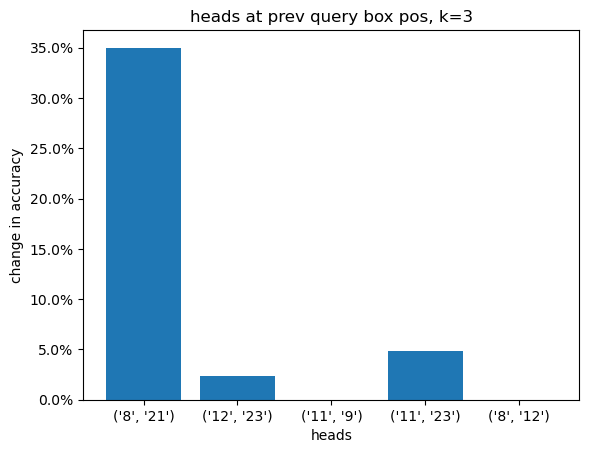

In [24]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

names = []
scores = []

for k in res:
    # new_k = string_to_tuple(k)
    names.append(str((k[0].split(".")[2], str(k[1]))))
    scores.append((res[k][0]/res[k][1] - 1))

plt.bar(names,scores)
plt.title("heads at prev query box pos, k=3")
plt.xlabel('heads')
plt.ylabel('change in accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

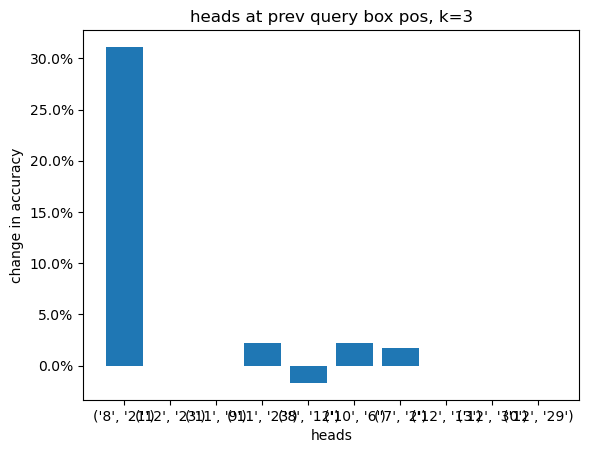

In [50]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

names = []
scores = []

for k in res:
    # new_k = string_to_tuple(k)
    names.append(str((k[0].split(".")[2], str(k[1]))))
    scores.append((res[k][0]/res[k][1] - 1))

plt.bar(names,scores)
plt.title("heads at prev query box pos, k=3")
plt.xlabel('heads')
plt.ylabel('change in accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

In [26]:
new = {}
for k in res:
    new[str(k)] = res[k]


with open("./new_data (50, 15, 30, 5)/llama_heads_at_prev_box_pos_res_k_2.json", "w") as outfile:
    json.dump(new, outfile)

### llama_head_at_query_box_token

In [15]:
import json

with open("./new_data (50, 15, 30, 5)/head_at_query_box_token_300.json", 'r') as f:
    data = json.load(f)

ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]),reverse=True)


In [16]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

res = {}

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=63, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=15, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=30, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx, head in tqdm(head_at_query_box_token):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"

    print(layer,head)
    for r in ranked[str((layer,head))][:math.ceil(0.3*len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        print("remove",top_layer, top_head)
        circuit_components[2][top_layer].remove(top_head)

    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[2][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer,head)] = (befor,after)
    
    for r in ranked[str((layer,head))][:math.ceil(0.3*len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        circuit_components[2][top_layer].append(top_head)
    circuit_components[2][layer].append(head)

50 15 30 5


  0%|          | 0/30 [00:00<?, ?it/s]

model.layers.10.self_attn.o_proj 3
remove model.layers.9.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 17
remove model.layers.7.self_attn.o_proj 3
remove model.layers.6.self_attn.o_proj 10
remove model.layers.11.self_attn.o_proj 7



100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.51



  3%|▎         | 1/30 [01:16<36:56, 76.44s/it]

Task accuracy: 0.36
model.layers.13.self_attn.o_proj 14
remove model.layers.9.self_attn.o_proj 2
remove model.layers.6.self_attn.o_proj 10
remove model.layers.9.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 23
remove model.layers.7.self_attn.o_proj 17
remove model.layers.4.self_attn.o_proj 4



100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.47



  7%|▋         | 2/30 [02:31<35:20, 75.74s/it]

Task accuracy: 0.43
model.layers.9.self_attn.o_proj 2



100%|██████████| 6/6 [00:37<00:00,  6.21s/it]


Task accuracy: 0.56



 10%|█         | 3/30 [03:46<33:52, 75.29s/it]

Task accuracy: 0.6
model.layers.11.self_attn.o_proj 23
remove model.layers.13.self_attn.o_proj 14
remove model.layers.5.self_attn.o_proj 7
remove model.layers.9.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 9
remove model.layers.8.self_attn.o_proj 1



100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.53



 13%|█▎        | 4/30 [05:02<32:42, 75.50s/it]

Task accuracy: 0.5
model.layers.1.self_attn.o_proj 9
remove model.layers.7.self_attn.o_proj 3
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 9
remove model.layers.9.self_attn.o_proj 2
remove model.layers.13.self_attn.o_proj 0
remove model.layers.6.self_attn.o_proj 10



100%|██████████| 6/6 [00:38<00:00,  6.33s/it]


Task accuracy: 0.52



 17%|█▋        | 5/30 [06:18<31:34, 75.77s/it]

Task accuracy: 0.51
model.layers.9.self_attn.o_proj 7



100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.56



 20%|██        | 6/30 [07:34<30:23, 75.98s/it]

Task accuracy: 0.59
model.layers.9.self_attn.o_proj 10
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 9
remove model.layers.10.self_attn.o_proj 7
remove model.layers.13.self_attn.o_proj 14
remove model.layers.6.self_attn.o_proj 10
remove model.layers.11.self_attn.o_proj 7



100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.51



 23%|██▎       | 7/30 [08:49<29:00, 75.69s/it]

Task accuracy: 0.43
model.layers.7.self_attn.o_proj 17
remove model.layers.6.self_attn.o_proj 10
remove model.layers.7.self_attn.o_proj 9
remove model.layers.9.self_attn.o_proj 2
remove model.layers.9.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4



100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.53



 27%|██▋       | 8/30 [10:06<27:48, 75.85s/it]

Task accuracy: 0.5
model.layers.11.self_attn.o_proj 24
remove model.layers.7.self_attn.o_proj 9



100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.57



 30%|███       | 9/30 [11:20<26:25, 75.49s/it]

Task accuracy: 0.56
model.layers.7.self_attn.o_proj 26
remove model.layers.6.self_attn.o_proj 10
remove model.layers.9.self_attn.o_proj 2



100%|██████████| 6/6 [00:37<00:00,  6.21s/it]


Task accuracy: 0.57



 33%|███▎      | 10/30 [12:35<25:03, 75.20s/it]

Task accuracy: 0.56
model.layers.4.self_attn.o_proj 4
remove model.layers.6.self_attn.o_proj 10
remove model.layers.10.self_attn.o_proj 3
remove model.layers.9.self_attn.o_proj 7
remove model.layers.7.self_attn.o_proj 17
remove model.layers.7.self_attn.o_proj 9



100%|██████████| 6/6 [00:37<00:00,  6.21s/it]


Task accuracy: 0.41



 37%|███▋      | 11/30 [13:50<23:45, 75.02s/it]

Task accuracy: 0.35
model.layers.13.self_attn.o_proj 0
remove model.layers.6.self_attn.o_proj 10



100%|██████████| 6/6 [00:37<00:00,  6.20s/it]


Task accuracy: 0.56



 40%|████      | 12/30 [15:04<22:27, 74.87s/it]

Task accuracy: 0.55
model.layers.6.self_attn.o_proj 10
remove model.layers.4.self_attn.o_proj 4
remove model.layers.9.self_attn.o_proj 2
remove model.layers.7.self_attn.o_proj 17
remove model.layers.7.self_attn.o_proj 26
remove model.layers.7.self_attn.o_proj 9
remove model.layers.10.self_attn.o_proj 7



100%|██████████| 6/6 [00:37<00:00,  6.21s/it]


Task accuracy: 0.55



 43%|████▎     | 13/30 [16:19<21:14, 74.99s/it]

Task accuracy: 0.49
model.layers.7.self_attn.o_proj 9
remove model.layers.6.self_attn.o_proj 10
remove model.layers.7.self_attn.o_proj 17
remove model.layers.9.self_attn.o_proj 2
remove model.layers.5.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4



100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.54



 47%|████▋     | 14/30 [17:35<20:01, 75.09s/it]

Task accuracy: 0.54
model.layers.5.self_attn.o_proj 7
remove model.layers.10.self_attn.o_proj 7
remove model.layers.7.self_attn.o_proj 9
remove model.layers.11.self_attn.o_proj 23
remove model.layers.12.self_attn.o_proj 23
remove model.layers.4.self_attn.o_proj 4
remove model.layers.11.self_attn.o_proj 24



100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.52



 50%|█████     | 15/30 [18:51<18:50, 75.39s/it]

Task accuracy: 0.51
model.layers.12.self_attn.o_proj 0
remove model.layers.11.self_attn.o_proj 7
remove model.layers.1.self_attn.o_proj 9
remove model.layers.9.self_attn.o_proj 7
remove model.layers.5.self_attn.o_proj 7
remove model.layers.12.self_attn.o_proj 9
remove model.layers.10.self_attn.o_proj 4



100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.57



 53%|█████▎    | 16/30 [20:06<17:33, 75.24s/it]

Task accuracy: 0.57
model.layers.8.self_attn.o_proj 1



100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.56



 57%|█████▋    | 17/30 [21:20<16:15, 75.07s/it]

Task accuracy: 0.57
model.layers.9.self_attn.o_proj 29
remove model.layers.6.self_attn.o_proj 10
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 9
remove model.layers.10.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 24
remove model.layers.13.self_attn.o_proj 0



100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


Task accuracy: 0.52



 60%|██████    | 18/30 [22:35<14:59, 74.95s/it]

Task accuracy: 0.52
model.layers.12.self_attn.o_proj 9
remove model.layers.11.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4



100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


Task accuracy: 0.57



 63%|██████▎   | 19/30 [23:50<13:44, 74.92s/it]

Task accuracy: 0.57
model.layers.7.self_attn.o_proj 3
remove model.layers.9.self_attn.o_proj 2
remove model.layers.1.self_attn.o_proj 9
remove model.layers.6.self_attn.o_proj 10



100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.59



 67%|██████▋   | 20/30 [25:04<12:28, 74.82s/it]

Task accuracy: 0.58
model.layers.11.self_attn.o_proj 7
remove model.layers.10.self_attn.o_proj 7
remove model.layers.12.self_attn.o_proj 23
remove model.layers.7.self_attn.o_proj 26
remove model.layers.7.self_attn.o_proj 9
remove model.layers.8.self_attn.o_proj 1



100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


Task accuracy: 0.6



 70%|███████   | 21/30 [26:20<11:14, 74.93s/it]

Task accuracy: 0.6
model.layers.12.self_attn.o_proj 23
remove model.layers.5.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 7
remove model.layers.1.self_attn.o_proj 9
remove model.layers.9.self_attn.o_proj 7
remove model.layers.6.self_attn.o_proj 10
remove model.layers.13.self_attn.o_proj 26



100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.57



 73%|███████▎  | 22/30 [27:36<10:02, 75.35s/it]

Task accuracy: 0.56
model.layers.9.self_attn.o_proj 15
remove model.layers.9.self_attn.o_proj 2
remove model.layers.9.self_attn.o_proj 7
remove model.layers.6.self_attn.o_proj 10
remove model.layers.5.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4



100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


Task accuracy: 0.56



 77%|███████▋  | 23/30 [28:52<08:48, 75.49s/it]

Task accuracy: 0.56
model.layers.10.self_attn.o_proj 21
remove model.layers.1.self_attn.o_proj 9
remove model.layers.5.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 3
remove model.layers.11.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.49



 80%|████████  | 24/30 [30:08<07:33, 75.61s/it]

Task accuracy: 0.48
model.layers.9.self_attn.o_proj 21
remove model.layers.5.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 7
remove model.layers.10.self_attn.o_proj 4
remove model.layers.9.self_attn.o_proj 7
remove model.layers.8.self_attn.o_proj 1
remove model.layers.13.self_attn.o_proj 14



100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.56



 83%|████████▎ | 25/30 [31:24<06:19, 75.82s/it]

Task accuracy: 0.43
model.layers.10.self_attn.o_proj 4
remove model.layers.9.self_attn.o_proj 7
remove model.layers.7.self_attn.o_proj 9
remove model.layers.10.self_attn.o_proj 3
remove model.layers.11.self_attn.o_proj 24
remove model.layers.5.self_attn.o_proj 7
remove model.layers.9.self_attn.o_proj 29



100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.48



 87%|████████▋ | 26/30 [32:40<05:03, 75.92s/it]

Task accuracy: 0.47
model.layers.10.self_attn.o_proj 7



100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.56



 90%|█████████ | 27/30 [33:57<03:48, 76.25s/it]

Task accuracy: 0.59
model.layers.13.self_attn.o_proj 26
remove model.layers.11.self_attn.o_proj 7
remove model.layers.12.self_attn.o_proj 23
remove model.layers.8.self_attn.o_proj 1



100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


Task accuracy: 0.56



 93%|█████████▎| 28/30 [35:14<02:32, 76.31s/it]

Task accuracy: 0.56
model.layers.13.self_attn.o_proj 12
remove model.layers.9.self_attn.o_proj 2
remove model.layers.6.self_attn.o_proj 10
remove model.layers.11.self_attn.o_proj 7



100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Task accuracy: 0.57



 97%|█████████▋| 29/30 [36:30<01:16, 76.41s/it]

Task accuracy: 0.57
model.layers.8.self_attn.o_proj 12
remove model.layers.10.self_attn.o_proj 4
remove model.layers.9.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 7
remove model.layers.10.self_attn.o_proj 7
remove model.layers.13.self_attn.o_proj 26
remove model.layers.7.self_attn.o_proj 17



100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.58



100%|██████████| 30/30 [37:46<00:00, 75.54s/it]

Task accuracy: 0.55


In [49]:
# with open("llama_head_at_query_box_token_res_k_10.json", "r") as file:
#     res = json.load(file)

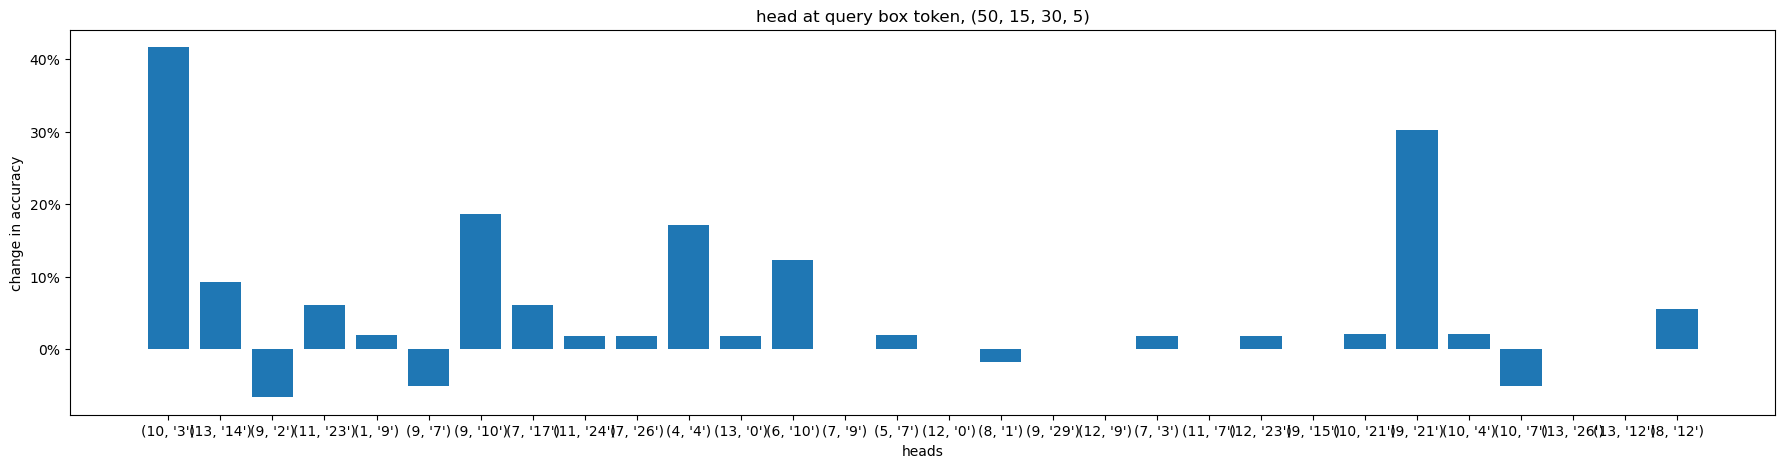

In [17]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

names = []
scores = []

for k in res:
    new_k = string_to_tuple(str(k))
    names.append(str((int(new_k[0].split(".")[2]), new_k[1])))
    scores.append((res[k][0]/res[k][1] - 1))

f, ax = plt.subplots(figsize=(22,5))
plt.bar(names,scores)
plt.title("head at query box token, (50, 15, 30, 5)")
plt.xlabel('heads')
plt.ylabel('change in accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

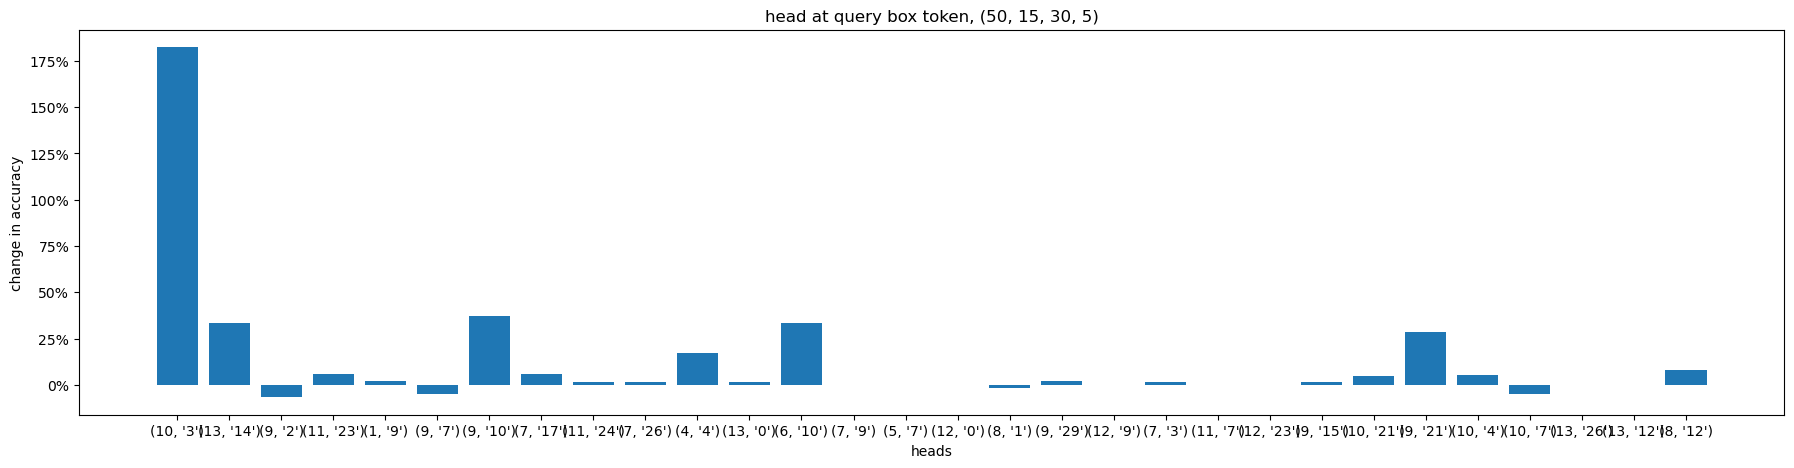

In [16]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

names = []
scores = []

for k in res:
    new_k = string_to_tuple(str(k))
    names.append(str((int(new_k[0].split(".")[2]), new_k[1])))
    scores.append((res[k][0]/res[k][1] - 1))

f, ax = plt.subplots(figsize=(22,5))
plt.bar(names,scores)
plt.title("head at query box token, (50, 15, 30, 5)")
plt.xlabel('heads')
plt.ylabel('change in accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

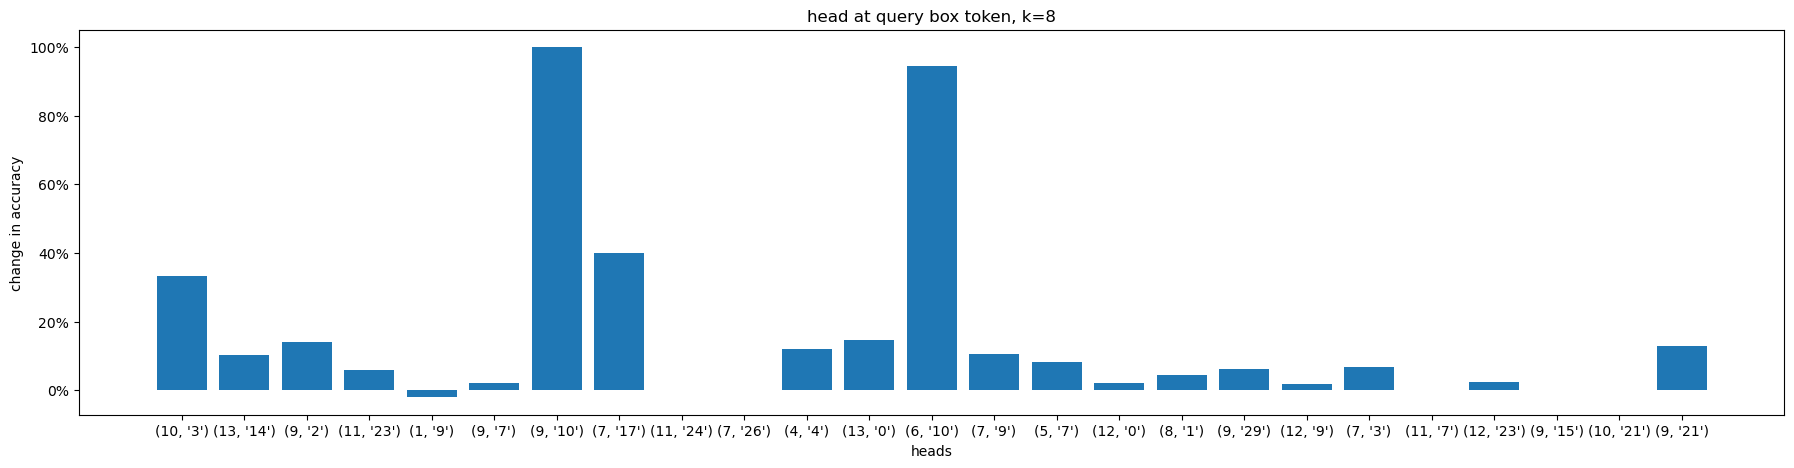

In [88]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

names = []
scores = []

for k in res:
    new_k = string_to_tuple(str(k))
    names.append(str((int(new_k[0].split(".")[2]), new_k[1])))
    scores.append((res[k][0]/res[k][1] - 1))

f, ax = plt.subplots(figsize=(22,5))
plt.bar(names,scores)
plt.title("head at query box token, k=8")
plt.xlabel('heads')
plt.ylabel('change in accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

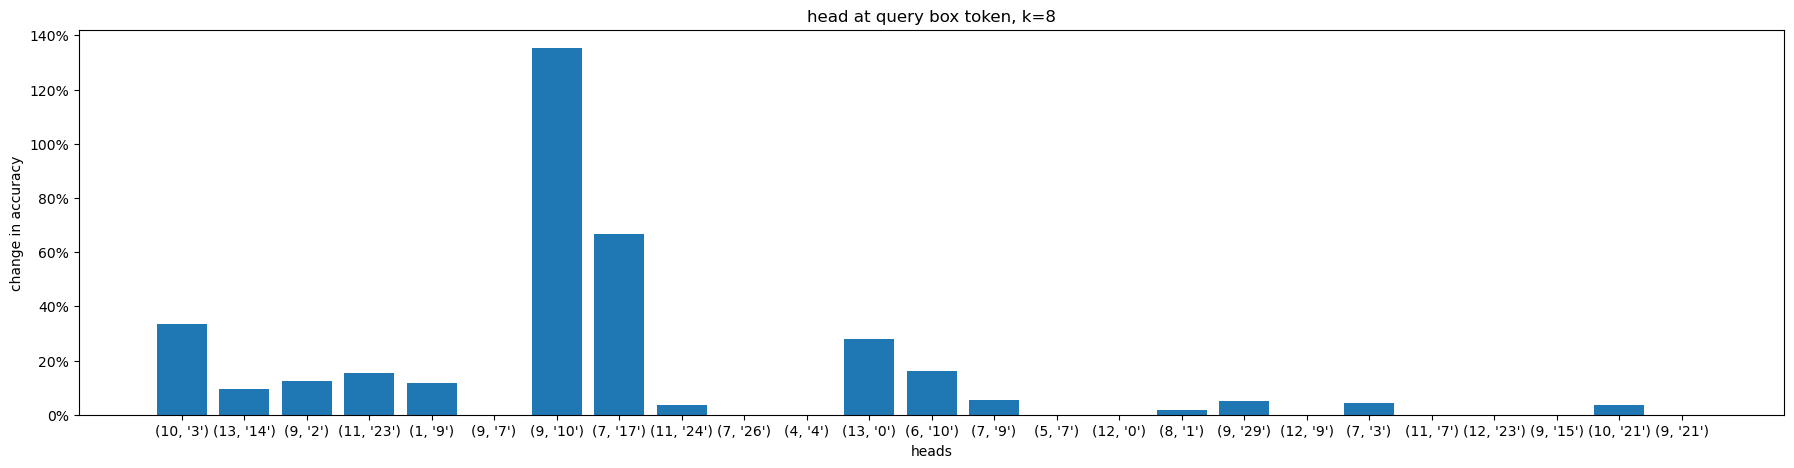

In [67]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

names = []
scores = []

for k in res:
    new_k = string_to_tuple(str(k))
    names.append(str((int(new_k[0].split(".")[2]), new_k[1])))
    scores.append((res[k][0]/res[k][1] - 1))

f, ax = plt.subplots(figsize=(22,5))
plt.bar(names,scores)
plt.title("head at query box token, k=8")
plt.xlabel('heads')
plt.ylabel('change in accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

In [18]:
new = {}
for k in res:
    new[str(k)] = res[k]


with open("./new_data (50, 15, 30, 5)/llama_head_at_query_box_token_res_k_10_0.2.json", "w") as outfile:
    json.dump(new, outfile)

### llama_heads_affecting_direct_logit_heads

In [34]:
import json

with open("./new_data (50, 15, 30, 5)/heads_affecting_direct_logit_heads.json", 'r') as f:
    data = json.load(f)

ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]),reverse=True)

In [14]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

res = {}

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=63, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=15, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=30, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx, head in tqdm(heads_affecting_direct_logit_heads):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    print(layer,head)
    
    for r in ranked[str((layer,head))][:math.ceil(0.3*len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        print("remove",top_layer, top_head)
        circuit_components[0][top_layer].remove(top_head)
    
    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[0][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer,head)] = (befor,after)
    
    for r in ranked[str((layer,head))][:math.ceil(0.3*len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        circuit_components[0][top_layer].append(top_head)
    circuit_components[0][layer].append(head)

50 15 30 5


  0%|          | 0/15 [00:00<?, ?it/s]

model.layers.14.self_attn.o_proj 27
remove model.layers.11.self_attn.o_proj 23
remove model.layers.13.self_attn.o_proj 14
remove model.layers.12.self_attn.o_proj 23
remove model.layers.17.self_attn.o_proj 26
remove model.layers.13.self_attn.o_proj 0



100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.51



  7%|▋         | 1/15 [01:16<17:45, 76.11s/it]

Task accuracy: 0.14
model.layers.11.self_attn.o_proj 23
remove model.layers.14.self_attn.o_proj 27
remove model.layers.17.self_attn.o_proj 26
remove model.layers.13.self_attn.o_proj 14
remove model.layers.12.self_attn.o_proj 23
remove model.layers.19.self_attn.o_proj 12



100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.31



 13%|█▎        | 2/15 [02:31<16:27, 75.95s/it]

Task accuracy: 0.15
model.layers.12.self_attn.o_proj 23
remove model.layers.14.self_attn.o_proj 27
remove model.layers.13.self_attn.o_proj 14



100%|██████████| 6/6 [00:38<00:00,  6.37s/it]


Task accuracy: 0.4



 20%|██        | 3/15 [03:47<15:10, 75.85s/it]

Task accuracy: 0.32
model.layers.19.self_attn.o_proj 12
remove model.layers.14.self_attn.o_proj 27



100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.46



 27%|██▋       | 4/15 [05:03<13:54, 75.86s/it]

Task accuracy: 0.45
model.layers.13.self_attn.o_proj 0
remove model.layers.14.self_attn.o_proj 27
remove model.layers.13.self_attn.o_proj 14
remove model.layers.16.self_attn.o_proj 2
remove model.layers.11.self_attn.o_proj 26
remove model.layers.14.self_attn.o_proj 0



100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.36



 33%|███▎      | 5/15 [06:19<12:38, 75.81s/it]

Task accuracy: 0.27
model.layers.16.self_attn.o_proj 2
remove model.layers.14.self_attn.o_proj 27
remove model.layers.13.self_attn.o_proj 14
remove model.layers.17.self_attn.o_proj 26



100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.4



 40%|████      | 6/15 [07:35<11:22, 75.85s/it]

Task accuracy: 0.39
model.layers.13.self_attn.o_proj 1
remove model.layers.13.self_attn.o_proj 14
remove model.layers.19.self_attn.o_proj 12
remove model.layers.16.self_attn.o_proj 2
remove model.layers.11.self_attn.o_proj 26



100%|██████████| 6/6 [00:38<00:00,  6.35s/it]


Task accuracy: 0.58



 47%|████▋     | 7/15 [08:51<10:07, 75.89s/it]

Task accuracy: 0.58
model.layers.11.self_attn.o_proj 26
remove model.layers.17.self_attn.o_proj 26



100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.58



 53%|█████▎    | 8/15 [10:06<08:51, 75.86s/it]

Task accuracy: 0.58
model.layers.13.self_attn.o_proj 14
remove model.layers.14.self_attn.o_proj 27



100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.46



 60%|██████    | 9/15 [11:22<07:35, 75.87s/it]

Task accuracy: 0.4
model.layers.16.self_attn.o_proj 16
remove model.layers.16.self_attn.o_proj 2



100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.55



 67%|██████▋   | 10/15 [12:38<06:19, 75.85s/it]

Task accuracy: 0.55
model.layers.14.self_attn.o_proj 0
remove model.layers.14.self_attn.o_proj 27
remove model.layers.13.self_attn.o_proj 14



100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.4



 73%|███████▎  | 11/15 [13:54<05:02, 75.71s/it]

Task accuracy: 0.36
model.layers.14.self_attn.o_proj 13
remove model.layers.14.self_attn.o_proj 27
remove model.layers.13.self_attn.o_proj 14
remove model.layers.17.self_attn.o_proj 26
remove model.layers.16.self_attn.o_proj 2
remove model.layers.11.self_attn.o_proj 26



100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.39



 80%|████████  | 12/15 [15:09<03:46, 75.62s/it]

Task accuracy: 0.38
model.layers.10.self_attn.o_proj 6
remove model.layers.14.self_attn.o_proj 27



100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.46



 87%|████████▋ | 13/15 [16:25<02:31, 75.70s/it]

Task accuracy: 0.45
model.layers.17.self_attn.o_proj 26
remove model.layers.14.self_attn.o_proj 27



100%|██████████| 6/6 [00:38<00:00,  6.35s/it]


Task accuracy: 0.46



 93%|█████████▎| 14/15 [17:41<01:15, 75.79s/it]

Task accuracy: 0.44
model.layers.12.self_attn.o_proj 0
remove model.layers.14.self_attn.o_proj 27
remove model.layers.13.self_attn.o_proj 14
remove model.layers.19.self_attn.o_proj 12
remove model.layers.16.self_attn.o_proj 2



100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


Task accuracy: 0.38



100%|██████████| 15/15 [18:56<00:00, 75.77s/it]

Task accuracy: 0.37


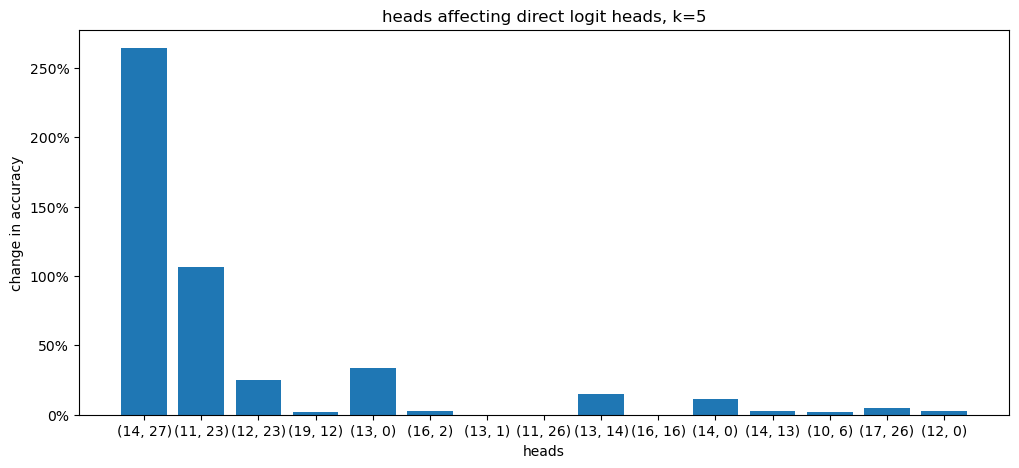

In [16]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_heads_affecting_direct_logit_heads_res_k_5.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    new_k = str(k)
    names.append(str((int(new_k.split(".")[2]),int(new_k.split(",")[1][1:-1]))))
    scores.append((res[k][0]/res[k][1] - 1))

f, ax = plt.subplots(figsize=(12,5))
plt.bar(names,scores)
plt.title("heads affecting direct logit heads, k=5")
plt.xlabel('heads')
plt.ylabel('change in accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

In [17]:
new = {}
for k in res:
    new[str(k)] = res[k]

with open("./new_data (50, 15, 30, 5)/llama_heads_affecting_direct_logit_heads_res_k_15.json", "w") as outfile:
    json.dump(new, outfile)

### llama_direct_logit_heads

In [33]:
data

{"('model.layers.15.self_attn.o_proj', 13)": {"('model.layers.15.self_attn.o_proj', 13)": 0.53,
  "('model.layers.21.self_attn.o_proj', 3)": 0.53,
  "('model.layers.15.self_attn.o_proj', 18)": 0.51,
  "('model.layers.30.self_attn.o_proj', 4)": 0.53,
  "('model.layers.18.self_attn.o_proj', 8)": 0.53,
  "('model.layers.24.self_attn.o_proj', 5)": 0.5,
  "('model.layers.29.self_attn.o_proj', 7)": 0.52,
  "('model.layers.18.self_attn.o_proj', 3)": 0.52,
  "('model.layers.23.self_attn.o_proj', 15)": 0.54,
  "('model.layers.20.self_attn.o_proj', 14)": 0.51,
  "('model.layers.17.self_attn.o_proj', 28)": 0.51,
  "('model.layers.21.self_attn.o_proj', 4)": 0.52,
  "('model.layers.15.self_attn.o_proj', 5)": 0.53,
  "('model.layers.23.self_attn.o_proj', 5)": 0.53,
  "('model.layers.17.self_attn.o_proj', 27)": 0.51,
  "('model.layers.28.self_attn.o_proj', 17)": 0.53,
  "('model.layers.19.self_attn.o_proj', 30)": 0.53,
  "('model.layers.24.self_attn.o_proj', 8)": 0.54,
  "('model.layers.18.self_attn.

In [36]:
import json

with open("./new_data (50, 15, 30, 5)/direct_logit_heads.json", 'r') as f:
    data = json.load(f)

ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]),reverse=True)    

KeyError: "('model.layers.15.self_attn.o_proj', 5)"

In [ ]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

res = {}

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=63, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=15, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=30, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx, head in tqdm(direct_logit_heads):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    
    print(layer,head)
    for r in ranked[str((layer,head))][:math.ceil(0.3*len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        print("remove",top_layer, top_head)
        circuit_components[0][top_layer].remove(top_head)
    
    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[0][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer,head)] = (befor,after)
    
    for r in ranked[str((layer,head))][:math.ceil(0.3*len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        circuit_components[0][top_layer].append(top_head)
    circuit_components[0][layer].append(head)

50 15 25 10


  0%|          | 0/50 [00:00<?, ?it/s]

model.layers.15.self_attn.o_proj 13
remove model.layers.24.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 15
remove model.layers.20.self_attn.o_proj 14
remove model.layers.18.self_attn.o_proj 20
remove model.layers.30.self_attn.o_proj 4
remove model.layers.17.self_attn.o_proj 27
remove model.layers.18.self_attn.o_proj 28
remove model.layers.19.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 6
remove model.layers.15.self_attn.o_proj 2
remove model.layers.17.self_attn.o_proj 3
remove model.layers.21.self_attn.o_proj 26
remove model.layers.19.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 19
remove model.layers.19.self_attn.o_proj 26


  2%|▏         | 1/50 [01:15<1:01:32, 75.35s/it]

model.layers.21.self_attn.o_proj 3
remove model.layers.17.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 20
remove model.layers.22.self_attn.o_proj 5
remove model.layers.20.self_attn.o_proj 14
remove model.layers.19.self_attn.o_proj 2
remove model.layers.19.self_attn.o_proj 8
remove model.layers.30.self_attn.o_proj 4
remove model.layers.18.self_attn.o_proj 8
remove model.layers.29.self_attn.o_proj 7
remove model.layers.28.self_attn.o_proj 17
remove model.layers.24.self_attn.o_proj 8
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 17
remove model.layers.21.self_attn.o_proj 0
remove model.layers.28.self_attn.o_proj 16


  4%|▍         | 2/50 [02:30<1:00:16, 75.35s/it]

model.layers.15.self_attn.o_proj 18
remove model.layers.30.self_attn.o_proj 4
remove model.layers.24.self_attn.o_proj 5
remove model.layers.17.self_attn.o_proj 28
remove model.layers.19.self_attn.o_proj 2
remove model.layers.17.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 30
remove model.layers.21.self_attn.o_proj 0
remove model.layers.21.self_attn.o_proj 23
remove model.layers.22.self_attn.o_proj 5
remove model.layers.20.self_attn.o_proj 14
remove model.layers.15.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 13
remove model.layers.23.self_attn.o_proj 15
remove model.layers.28.self_attn.o_proj 17
remove model.layers.24.self_attn.o_proj 8


  6%|▌         | 3/50 [03:46<59:01, 75.34s/it]  

model.layers.30.self_attn.o_proj 4
remove model.layers.15.self_attn.o_proj 13
remove model.layers.15.self_attn.o_proj 18
remove model.layers.20.self_attn.o_proj 14
remove model.layers.15.self_attn.o_proj 5
remove model.layers.28.self_attn.o_proj 17
remove model.layers.17.self_attn.o_proj 3
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 0
remove model.layers.28.self_attn.o_proj 16
remove model.layers.19.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 19
remove model.layers.19.self_attn.o_proj 26
remove model.layers.18.self_attn.o_proj 25
remove model.layers.22.self_attn.o_proj 5


  8%|▊         | 4/50 [05:01<57:49, 75.42s/it]

model.layers.18.self_attn.o_proj 8
remove model.layers.17.self_attn.o_proj 3
remove model.layers.24.self_attn.o_proj 5
remove model.layers.20.self_attn.o_proj 14
remove model.layers.15.self_attn.o_proj 5
remove model.layers.24.self_attn.o_proj 8
remove model.layers.23.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 0
remove model.layers.15.self_attn.o_proj 12
remove model.layers.18.self_attn.o_proj 25
remove model.layers.22.self_attn.o_proj 5


 10%|█         | 5/50 [06:16<56:29, 75.33s/it]

model.layers.24.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 13
remove model.layers.17.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 20
remove model.layers.20.self_attn.o_proj 14
remove model.layers.15.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 18
remove model.layers.18.self_attn.o_proj 8
remove model.layers.19.self_attn.o_proj 2
remove model.layers.21.self_attn.o_proj 25
remove model.layers.21.self_attn.o_proj 0
remove model.layers.19.self_attn.o_proj 8
remove model.layers.19.self_attn.o_proj 25
remove model.layers.22.self_attn.o_proj 5
remove model.layers.17.self_attn.o_proj 27
remove model.layers.18.self_attn.o_proj 28


 12%|█▏        | 6/50 [07:31<55:13, 75.30s/it]

model.layers.29.self_attn.o_proj 7
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 0
remove model.layers.19.self_attn.o_proj 2
remove model.layers.17.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 30
remove model.layers.21.self_attn.o_proj 19
remove model.layers.18.self_attn.o_proj 25


 14%|█▍        | 7/50 [08:47<53:59, 75.34s/it]

model.layers.18.self_attn.o_proj 3
remove model.layers.21.self_attn.o_proj 26
remove model.layers.22.self_attn.o_proj 5
remove model.layers.17.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 20
remove model.layers.30.self_attn.o_proj 4
remove model.layers.15.self_attn.o_proj 5
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.15.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 25
remove model.layers.28.self_attn.o_proj 16
remove model.layers.19.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 25
remove model.layers.15.self_attn.o_proj 1


 16%|█▌        | 8/50 [10:03<52:48, 75.43s/it]

model.layers.23.self_attn.o_proj 15
remove model.layers.15.self_attn.o_proj 13
remove model.layers.17.self_attn.o_proj 3
remove model.layers.19.self_attn.o_proj 8


 18%|█▊        | 9/50 [11:18<51:30, 75.38s/it]

model.layers.20.self_attn.o_proj 14
remove model.layers.15.self_attn.o_proj 13
remove model.layers.24.self_attn.o_proj 8
remove model.layers.24.self_attn.o_proj 5
remove model.layers.18.self_attn.o_proj 28
remove model.layers.21.self_attn.o_proj 25
remove model.layers.30.self_attn.o_proj 4
remove model.layers.18.self_attn.o_proj 8
remove model.layers.19.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 6
remove model.layers.17.self_attn.o_proj 3
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 17
remove model.layers.19.self_attn.o_proj 8
remove model.layers.15.self_attn.o_proj 9


 20%|██        | 10/50 [12:33<50:17, 75.43s/it]

model.layers.17.self_attn.o_proj 28
remove model.layers.18.self_attn.o_proj 20
remove model.layers.15.self_attn.o_proj 18
remove model.layers.15.self_attn.o_proj 2
remove model.layers.21.self_attn.o_proj 0
remove model.layers.22.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 13
remove model.layers.17.self_attn.o_proj 3
remove model.layers.21.self_attn.o_proj 19
remove model.layers.30.self_attn.o_proj 4
remove model.layers.24.self_attn.o_proj 5
remove model.layers.18.self_attn.o_proj 3
remove model.layers.20.self_attn.o_proj 14
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25


 22%|██▏       | 11/50 [13:49<49:04, 75.51s/it]

model.layers.21.self_attn.o_proj 4
remove model.layers.24.self_attn.o_proj 8
remove model.layers.17.self_attn.o_proj 3
remove model.layers.22.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 13
remove model.layers.24.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 15
remove model.layers.28.self_attn.o_proj 17
remove model.layers.19.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 6
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.15.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 30


 24%|██▍       | 12/50 [15:04<47:46, 75.44s/it]

model.layers.15.self_attn.o_proj 5
remove model.layers.30.self_attn.o_proj 4
remove model.layers.18.self_attn.o_proj 8
remove model.layers.19.self_attn.o_proj 8
remove model.layers.22.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 18
remove model.layers.18.self_attn.o_proj 3
remove model.layers.29.self_attn.o_proj 7
remove model.layers.20.self_attn.o_proj 14
remove model.layers.24.self_attn.o_proj 8
remove model.layers.19.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 6
remove model.layers.31.self_attn.o_proj 26
remove model.layers.17.self_attn.o_proj 3
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20


 26%|██▌       | 13/50 [16:20<46:29, 75.40s/it]

model.layers.23.self_attn.o_proj 5
remove model.layers.22.self_attn.o_proj 5
remove model.layers.30.self_attn.o_proj 4
remove model.layers.18.self_attn.o_proj 8
remove model.layers.28.self_attn.o_proj 17
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.17.self_attn.o_proj 3
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 30
remove model.layers.21.self_attn.o_proj 0
remove model.layers.28.self_attn.o_proj 16
remove model.layers.14.self_attn.o_proj 11
remove model.layers.31.self_attn.o_proj 29
remove model.layers.19.self_attn.o_proj 8


 28%|██▊       | 14/50 [17:35<45:12, 75.36s/it]

model.layers.17.self_attn.o_proj 27
remove model.layers.17.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 13
remove model.layers.18.self_attn.o_proj 20
remove model.layers.24.self_attn.o_proj 5
remove model.layers.20.self_attn.o_proj 14
remove model.layers.19.self_attn.o_proj 2
remove model.layers.21.self_attn.o_proj 26
remove model.layers.19.self_attn.o_proj 26
remove model.layers.30.self_attn.o_proj 4
remove model.layers.23.self_attn.o_proj 15
remove model.layers.24.self_attn.o_proj 8
remove model.layers.15.self_attn.o_proj 6
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 30


 30%|███       | 15/50 [18:50<43:56, 75.34s/it]

model.layers.28.self_attn.o_proj 17
remove model.layers.30.self_attn.o_proj 4
remove model.layers.24.self_attn.o_proj 8
remove model.layers.15.self_attn.o_proj 2
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 17
remove model.layers.19.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 19
remove model.layers.18.self_attn.o_proj 6
remove model.layers.19.self_attn.o_proj 26
remove model.layers.18.self_attn.o_proj 25
remove model.layers.22.self_attn.o_proj 5


 32%|███▏      | 16/50 [20:05<42:40, 75.31s/it]

model.layers.19.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 15
remove model.layers.17.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 19
remove model.layers.22.self_attn.o_proj 5
remove model.layers.19.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 25
remove model.layers.19.self_attn.o_proj 8
remove model.layers.19.self_attn.o_proj 26
remove model.layers.30.self_attn.o_proj 4
remove model.layers.28.self_attn.o_proj 17
remove model.layers.15.self_attn.o_proj 6
remove model.layers.31.self_attn.o_proj 26
remove model.layers.23.self_attn.o_proj 30


 34%|███▍      | 17/50 [21:21<41:25, 75.31s/it]

model.layers.24.self_attn.o_proj 8
remove model.layers.20.self_attn.o_proj 14
remove model.layers.18.self_attn.o_proj 20


 36%|███▌      | 18/50 [22:36<40:11, 75.37s/it]

model.layers.18.self_attn.o_proj 28
remove model.layers.18.self_attn.o_proj 20
remove model.layers.20.self_attn.o_proj 14
remove model.layers.15.self_attn.o_proj 13
remove model.layers.17.self_attn.o_proj 3
remove model.layers.21.self_attn.o_proj 0
remove model.layers.24.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 6
remove model.layers.19.self_attn.o_proj 8
remove model.layers.30.self_attn.o_proj 4
remove model.layers.18.self_attn.o_proj 8
remove model.layers.24.self_attn.o_proj 8
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.31.self_attn.o_proj 25


 38%|███▊      | 19/50 [23:52<38:55, 75.34s/it]

model.layers.23.self_attn.o_proj 20
remove model.layers.18.self_attn.o_proj 20
remove model.layers.18.self_attn.o_proj 8
remove model.layers.19.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 6
remove model.layers.17.self_attn.o_proj 3
remove model.layers.22.self_attn.o_proj 5
remove model.layers.20.self_attn.o_proj 14
remove model.layers.15.self_attn.o_proj 13
remove model.layers.30.self_attn.o_proj 4
remove model.layers.24.self_attn.o_proj 5
remove model.layers.29.self_attn.o_proj 7
remove model.layers.28.self_attn.o_proj 17
remove model.layers.24.self_attn.o_proj 8
remove model.layers.31.self_attn.o_proj 26
remove model.layers.15.self_attn.o_proj 2


 40%|████      | 20/50 [25:07<37:41, 75.38s/it]

model.layers.19.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 13
remove model.layers.15.self_attn.o_proj 18
remove model.layers.24.self_attn.o_proj 5
remove model.layers.29.self_attn.o_proj 7
remove model.layers.20.self_attn.o_proj 14
remove model.layers.23.self_attn.o_proj 20
remove model.layers.15.self_attn.o_proj 6
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 30
remove model.layers.21.self_attn.o_proj 0
remove model.layers.14.self_attn.o_proj 11
remove model.layers.21.self_attn.o_proj 26
remove model.layers.19.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 6


 42%|████▏     | 21/50 [26:23<36:27, 75.44s/it]

model.layers.15.self_attn.o_proj 6
remove model.layers.22.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 13
remove model.layers.20.self_attn.o_proj 14
remove model.layers.23.self_attn.o_proj 20
remove model.layers.19.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 2
remove model.layers.17.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 0
remove model.layers.18.self_attn.o_proj 28


 44%|████▍     | 22/50 [27:38<35:12, 75.45s/it]

model.layers.31.self_attn.o_proj 26
remove model.layers.18.self_attn.o_proj 3


 46%|████▌     | 23/50 [28:54<33:57, 75.46s/it]

model.layers.21.self_attn.o_proj 25
remove model.layers.19.self_attn.o_proj 8
remove model.layers.20.self_attn.o_proj 14
remove model.layers.24.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 15
remove model.layers.15.self_attn.o_proj 2
remove model.layers.17.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 30
remove model.layers.21.self_attn.o_proj 0
remove model.layers.21.self_attn.o_proj 19
remove model.layers.18.self_attn.o_proj 3


 48%|████▊     | 24/50 [30:09<32:44, 75.55s/it]

model.layers.15.self_attn.o_proj 2
remove model.layers.18.self_attn.o_proj 20
remove model.layers.24.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 13
remove model.layers.17.self_attn.o_proj 28
remove model.layers.28.self_attn.o_proj 17
remove model.layers.15.self_attn.o_proj 6
remove model.layers.21.self_attn.o_proj 25
remove model.layers.17.self_attn.o_proj 3
remove model.layers.31.self_attn.o_proj 25
remove model.layers.28.self_attn.o_proj 16
remove model.layers.14.self_attn.o_proj 11
remove model.layers.31.self_attn.o_proj 29
remove model.layers.19.self_attn.o_proj 8
remove model.layers.19.self_attn.o_proj 25
remove model.layers.22.self_attn.o_proj 5


 50%|█████     | 25/50 [31:25<31:27, 75.51s/it]

model.layers.17.self_attn.o_proj 3
remove model.layers.17.self_attn.o_proj 27
remove model.layers.18.self_attn.o_proj 8
remove model.layers.24.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 15
remove model.layers.14.self_attn.o_proj 11


 52%|█████▏    | 26/50 [32:40<30:10, 75.43s/it]

model.layers.31.self_attn.o_proj 25
remove model.layers.30.self_attn.o_proj 4
remove model.layers.20.self_attn.o_proj 14
remove model.layers.19.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 2
remove model.layers.17.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 17
remove model.layers.21.self_attn.o_proj 0
remove model.layers.28.self_attn.o_proj 16
remove model.layers.14.self_attn.o_proj 11
remove model.layers.19.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 19
remove model.layers.19.self_attn.o_proj 26
remove model.layers.22.self_attn.o_proj 5


 54%|█████▍    | 27/50 [33:55<28:53, 75.39s/it]

model.layers.18.self_attn.o_proj 20


 56%|█████▌    | 28/50 [35:11<27:38, 75.39s/it]

model.layers.23.self_attn.o_proj 30
remove model.layers.15.self_attn.o_proj 18
remove model.layers.29.self_attn.o_proj 7
remove model.layers.19.self_attn.o_proj 2
remove model.layers.21.self_attn.o_proj 25
remove model.layers.31.self_attn.o_proj 25
remove model.layers.19.self_attn.o_proj 26


 58%|█████▊    | 29/50 [36:26<26:23, 75.40s/it]

model.layers.23.self_attn.o_proj 17
remove model.layers.18.self_attn.o_proj 20


 60%|██████    | 30/50 [37:41<25:07, 75.39s/it]

model.layers.21.self_attn.o_proj 0
remove model.layers.29.self_attn.o_proj 7
remove model.layers.19.self_attn.o_proj 8


 62%|██████▏   | 31/50 [38:57<23:53, 75.45s/it]

model.layers.28.self_attn.o_proj 16
remove model.layers.30.self_attn.o_proj 4
remove model.layers.15.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 25
remove model.layers.19.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 6
remove model.layers.18.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 19


 64%|██████▍   | 32/50 [40:12<22:37, 75.43s/it]

model.layers.23.self_attn.o_proj 19
remove model.layers.18.self_attn.o_proj 20
remove model.layers.24.self_attn.o_proj 8
remove model.layers.17.self_attn.o_proj 3
remove model.layers.21.self_attn.o_proj 0
remove model.layers.21.self_attn.o_proj 19
remove model.layers.22.self_attn.o_proj 5
remove model.layers.30.self_attn.o_proj 4
remove model.layers.24.self_attn.o_proj 5
remove model.layers.20.self_attn.o_proj 14
remove model.layers.28.self_attn.o_proj 16
remove model.layers.21.self_attn.o_proj 26
remove model.layers.19.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 8
remove model.layers.23.self_attn.o_proj 15
remove model.layers.19.self_attn.o_proj 2


 66%|██████▌   | 33/50 [41:27<21:20, 75.34s/it]

model.layers.14.self_attn.o_proj 11
remove model.layers.17.self_attn.o_proj 3
remove model.layers.19.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 0
remove model.layers.22.self_attn.o_proj 5


 68%|██████▊   | 34/50 [42:43<20:05, 75.31s/it]

model.layers.21.self_attn.o_proj 26
remove model.layers.18.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 13
remove model.layers.23.self_attn.o_proj 15
remove model.layers.19.self_attn.o_proj 2
remove model.layers.17.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 17
remove model.layers.21.self_attn.o_proj 0
remove model.layers.19.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 25
remove model.layers.22.self_attn.o_proj 5
remove model.layers.20.self_attn.o_proj 14
remove model.layers.17.self_attn.o_proj 27
remove model.layers.15.self_attn.o_proj 2
remove model.layers.23.self_attn.o_proj 19


 70%|███████   | 35/50 [43:58<18:49, 75.31s/it]

model.layers.31.self_attn.o_proj 29
remove model.layers.15.self_attn.o_proj 2


In [ ]:
new = {}
for k in res:
    new[str(k)] = res[k]

with open("./new_data (50, 15, 25, 10)/llama_direct_logit_heads_res_k_15.json", "w") as outfile:
    json.dump(new, outfile)

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_direct_logit_heads_res_k_15.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    new_k = str(k)
    names.append(str((int(new_k.split(".")[2]),int(new_k.split(",")[1][1:-1]))))
    scores.append((res[k][0]/res[k][1] - 1))

f, ax = plt.subplots(figsize=(22,5))
plt.bar(names,scores)
plt.title("direct logit heads, k=15")
plt.xlabel('heads')
plt.ylabel('change in accuracy')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

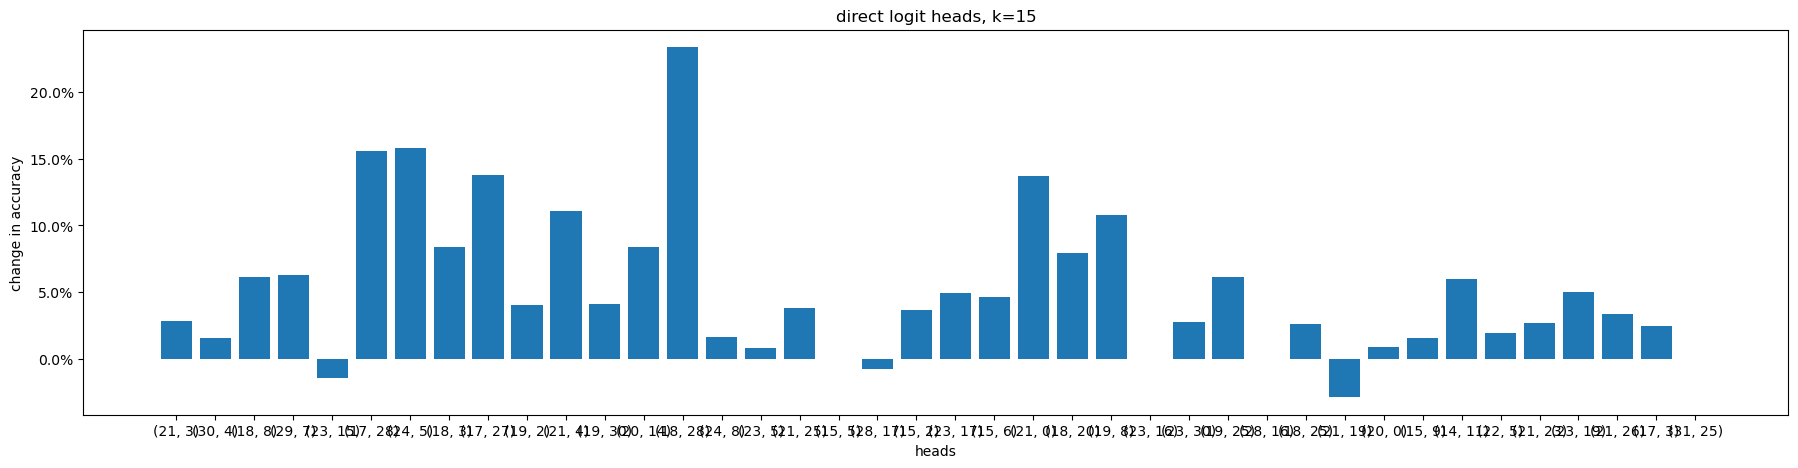

In [56]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_direct_logit_heads_res_k_15.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    names.append(str((int(k.split(".")[2]),int(k.split(",")[1][1:-1]))))
    scores.append((res[k][0]/res[k][1] - 1))

f, ax = plt.subplots(figsize=(22,5))
plt.bar(names,scores)
plt.title("direct logit heads, k=15")
plt.xlabel('heads')
plt.ylabel('change in accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

## Remove nodes with low score 


In [21]:
with open('./new_data (50, 15, 25, 10)/llama_direct_logit_heads_res_k_15.json', 'r') as f:
    llama_direct_logit_heads_res_k_15 = json.load(f)
    
with open('./new_data (50, 15, 30, 5)/llama_head_at_query_box_token_res_k_10_0.2.json', 'r') as f:
    llama_head_at_query_box_token_res_k_10 = json.load(f)

with open('./new_data (50, 15, 25, 10)/llama_heads_affecting_direct_logit_heads_res_k_15.json', 'r') as f:
    llama_heads_affecting_direct_logit_heads_res_k_5 = json.load(f)
    
with open('./new_data (50, 15, 30, 5)/llama_heads_at_prev_box_pos_res_k_2.json', 'r') as f:
    llama_heads_at_prev_box_pos_k_3 = json.load(f)


In [22]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

root_path = "../new_pp_exps/reverse/final_7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=63, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=15, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=30, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

minimality_threshold = 0.5/100

for k in llama_direct_logit_heads_res_k_15:
    if (llama_direct_logit_heads_res_k_15[k][0] / llama_direct_logit_heads_res_k_15[k][1]) - 1 < minimality_threshold:
        head = [int(k.split(".")[2]), int(k.split(",")[1][1:-1])]
        direct_logit_heads.remove(head)

for k in llama_head_at_query_box_token_res_k_10:
    if (llama_head_at_query_box_token_res_k_10[k][0] / llama_head_at_query_box_token_res_k_10[k][1]) - 1 < minimality_threshold:
        head = [int(k.split(".")[2]), int(k.split(",")[1][1:-1])]
        head_at_query_box_token.remove(head)

for k in llama_heads_affecting_direct_logit_heads_res_k_5:
    if (llama_heads_affecting_direct_logit_heads_res_k_5[k][0] / llama_heads_affecting_direct_logit_heads_res_k_5[k][1]) - 1 < minimality_threshold:
        head = [int(k.split(".")[2]), int(k.split(",")[1][1:-1])]
        heads_affecting_direct_logit_heads.remove(head)

for k in llama_heads_at_prev_box_pos_k_3:
    if (llama_heads_at_prev_box_pos_k_3[k][0] / llama_heads_at_prev_box_pos_k_3[k][1]) - 1 < minimality_threshold:
        head = [int(k.split(".")[2]), int(k.split(",")[1][1:-1])]
        heads_at_prev_box_pos.remove(head)

print(f"Direct Logit Heads: {len(direct_logit_heads)}")
print(f"Heads Affecting Direct Logit Heads: {len(heads_affecting_direct_logit_heads)}")
print(f"Heads at Query Box Token: {len(head_at_query_box_token)}")
print(f"Heads at Prev Box Pos: {len(heads_at_prev_box_pos)}")
print(f"Total #heads: {len(direct_logit_heads) + len(heads_affecting_direct_logit_heads) + len(head_at_query_box_token) + len(heads_at_prev_box_pos)}")

Direct Logit Heads: 38
Heads Affecting Direct Logit Heads: 10
Heads at Query Box Token: 18
Heads at Prev Box Pos: 3
Total #heads: 69


In [23]:
for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)


for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)

In [24]:
eval(model, dataloader, modules, circuit_components, mean_activations)

100%|██████████| 10/10 [01:02<00:00,  6.26s/it]

Task accuracy: 0.59


0.59

In [85]:
circuit_heads = {
    "direct_logit_heads": direct_logit_heads,
    "heads_affecting_direct_logit_heads": heads_affecting_direct_logit_heads,
    "head_at_query_box_token": head_at_query_box_token,
    "heads_at_prev_box_pos": heads_at_prev_box_pos,
}

In [23]:
# Save circuit heads to json file
# with open("circuit_heads.json", "w") as outfile:
#     json.dump(circuit_heads, outfile)

## Circuit Performance

In [17]:
with open("../circuit_heads.json", "r") as file:
    circuit_heads = json.load(file)

In [18]:
direct_logit_heads = circuit_heads["direct_logit_heads"]
heads_affecting_direct_logit_heads = circuit_heads["heads_affecting_direct_logit_heads"]
head_at_query_box_token = circuit_heads["head_at_query_box_token"]
heads_at_prev_box_pos = circuit_heads["heads_at_prev_box_pos"]

print(f"Direct Logit Heads: {len(direct_logit_heads)}")
print(f"Heads Affecting Direct Logit Heads: {len(heads_affecting_direct_logit_heads)}")
print(f"Heads at Query Box Token: {len(head_at_query_box_token)}")
print(f"Heads at Prev Box Pos: {len(heads_at_prev_box_pos)}")
print(f"Total #heads: {len(direct_logit_heads) + len(heads_affecting_direct_logit_heads) + len(head_at_query_box_token) + len(heads_at_prev_box_pos)}")

Direct Logit Heads: 40
Heads Affecting Direct Logit Heads: 9
Heads at Query Box Token: 22
Heads at Prev Box Pos: 4
Total #heads: 75


In [19]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)


for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)

In [20]:
eval(model, dataloader, modules, circuit_components, mean_activations)

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [01:03<00:00,  6.33s/it]
10it [01:03,  6.33s/it]

Task accuracy: 0.64


0.64